# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.5 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.8 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage.

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.2, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

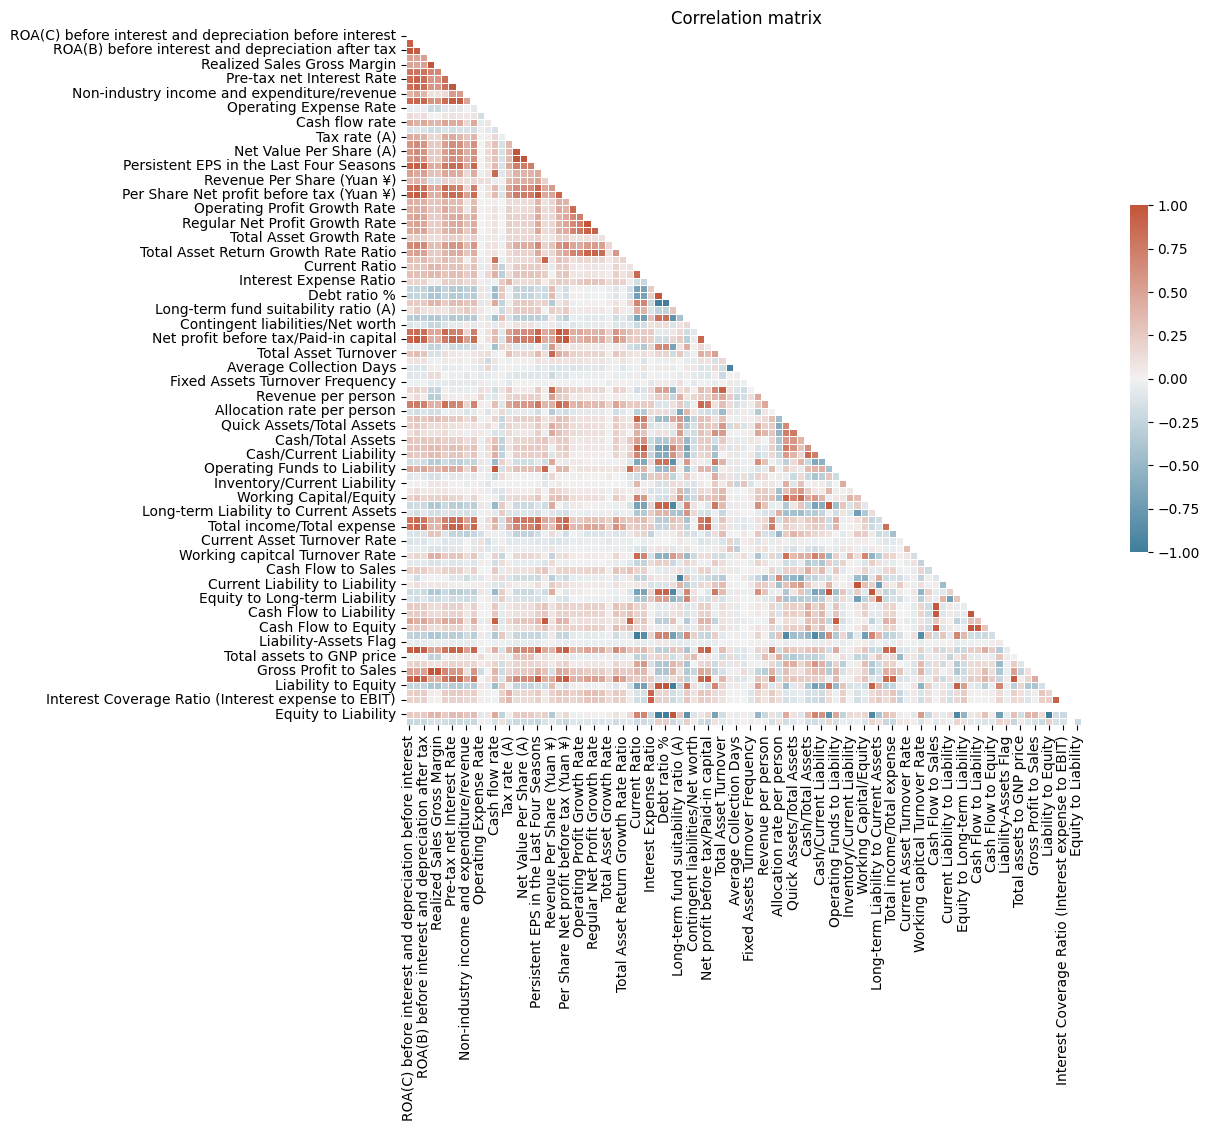

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.235663
Net profit before tax/Paid-in capital       0.230565
Net Income to Total Assets                  0.230513
Per Share Net profit before tax (Yuan ¥)    0.229934
                                              ...   
Cash Turnover Rate                          0.021378
Operating Expense Rate                      0.018537
Net Worth Turnover Rate (times)             0.011220
Inventory Turnover Rate (times)             0.006542
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

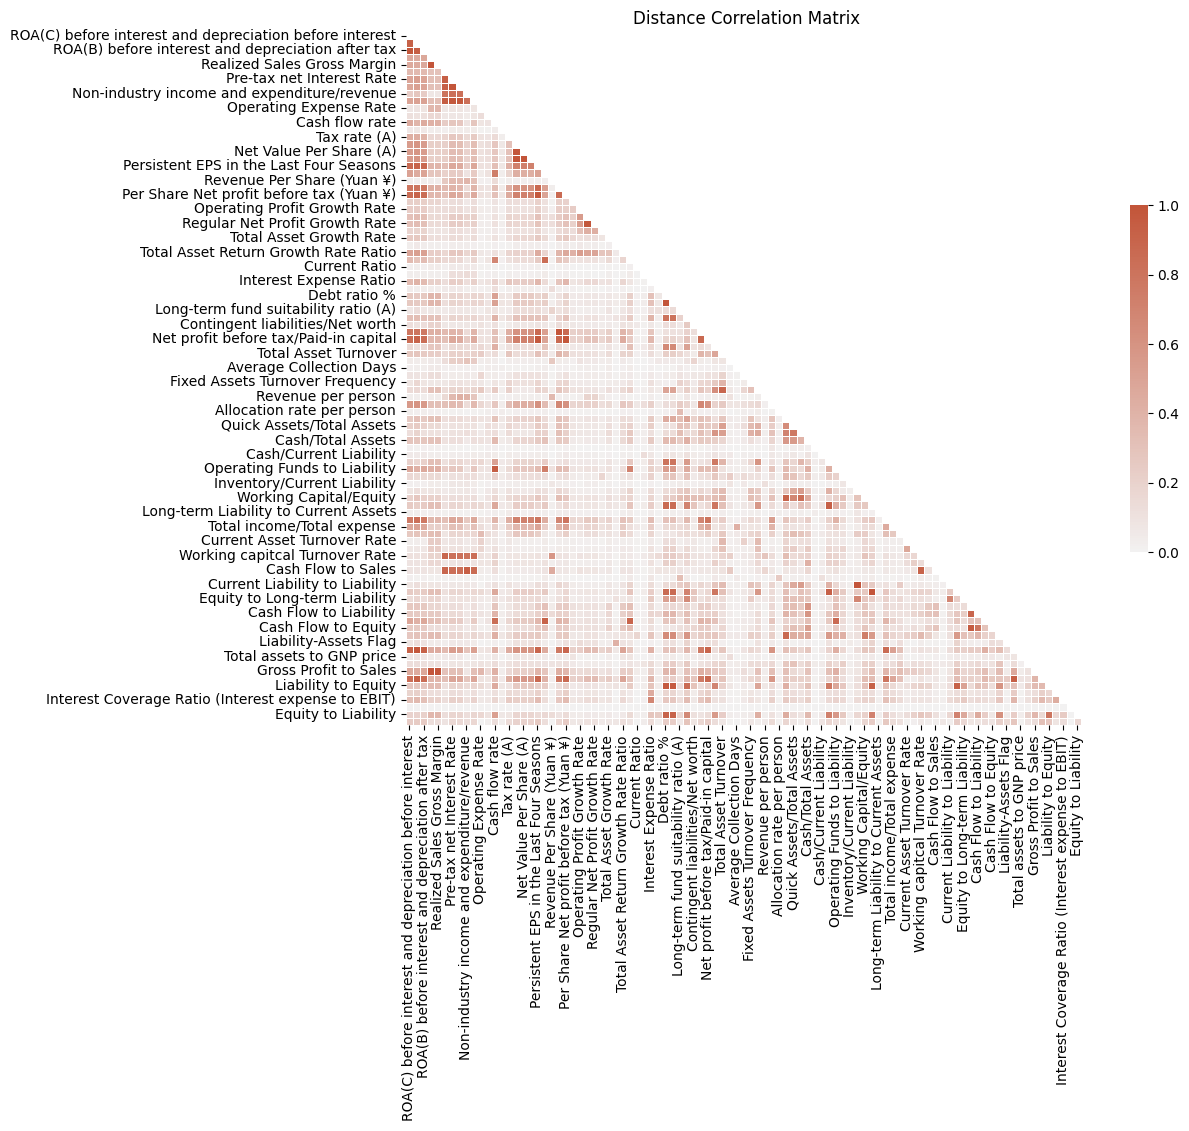

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

In [ ]:
taiwan_dist_corr['Target'].sort_values(ascending=False)

Target                                1.000000
Net Income to Stockholder's Equity    0.318214
Borrowing dependency                  0.293902
Net Income to Total Assets            0.274853
Liability to Equity                   0.267842
                                        ...   
Revenue Per Share (Yuan ¥)            0.004884
Operating Expense Rate                0.003952
Quick Assets/Current Liability        0.003496
Current Ratio                         0.002472
Net Income Flag                       0.000000
Name: Target, Length: 96, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train)

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(
      taiwan_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train.drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test.drop(columns=remove_columns)

Variance of each column:
ROA(C) before interest and depreciation before interest    0.003625
ROA(A) before interest and % after tax                     0.004205
ROA(B) before interest and depreciation after tax          0.003712
Operating Gross Margin                                     0.000289
Realized Sales Gross Margin                                0.000289
                                                             ...   
Degree of Financial Leverage (DFL)                         0.000264
Interest Coverage Ratio (Interest expense to EBIT)         0.000173
Net Income Flag                                            0.000000
Equity to Liability                                        0.002769
Target                                                     0.031229
Length: 96, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
{'Net Income Flag'}


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  95


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{'ROA(C) before interest and depreciation before interest': 0.502559352605665,
 'ROA(A) before interest and % after tax': 0.559474487570868,
 'ROA(B) before interest and depreciation after tax': 0.552063814979389,
 'Operating Gross Margin': 0.605939837703051,
 'Realized Sales Gross Margin': 0.605925424119691,
 'Operating Profit Rate': 0.999021892732888,
 'Pre-tax net Interest Rate': 0.797461397130791,
 'After-tax net Interest Rate': 0.809373766380128,
 'Non-industry income and expenditure/revenue': 0.303524767733389,
 'Continuous interest rate (after tax)': 0.781633272898093,
 'Operating Expense Rate': 0.0002726708526306,
 'Research and development expense rate': 543000000.0,
 'Cash flow rate': 0.464992493059225,
 'Interest-bearing debt interest rate': 0.0003200320032003,
 'Tax rate (A)': 0.0713634983297905,
 'Net Value Per Share (B)': 0.184273734777296,
 'Net Value Per Share (A)': 0.184273734777296,
 'Net Value Per Share (C)': 0.18435801272597,
 'Persistent EPS in the Last Four Season

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [None],
    'min_samples_split': [0.005],
    'min_samples_leaf': [0.001]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:06:49.527850

Nested Cross-validation Results:
Individual scores: [0.31794872 0.24489796 0.33526012]
Average nested CV score: 0.299 (+/- 0.078)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005}

Best Model Performance:
Best CV score: 0.299
2025-01-16 13:06:52.522371

Execution time: 0.05 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:00:44.062178

Nested Cross-validation Results:
Individual scores: [0.31794872 0.29803922 0.24666667]
Average nested CV score: 0.288 (+/- 0.060)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005}

Best Model Performance:
Best CV score: 0.299

2025-01-15 16:01:24.893914

Execution time: 0.68 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
9                Continuous interest rate (after tax)    0.313612  0.035618
35                         Total debt/Total net worth    0.220537  0.011328
33                                        Quick Ratio    0.192813  0.029539
57                     Quick Assets/Current Liability    0.141515  0.012554
18            Persistent EPS in the Last Four Seasons    0.112392  0.004657
0   ROA(C) before interest and depreciation before...    0.100816  0.018124
28                            Total Asset Growth Rate    0.073052  0.011335
61                          Inventory/Working Capital    0.069868  0.003597
8         Non-industry income and expenditure/revenue    0.063509  0.003834
13                Interest-bearing debt interest rate    0.047661  0.009595
73                                 Cash Turnover Rate    0.045019  0.005340
47                    Inventory Turnover Rate (times)    0.043944  0.005504
86                          Total assets to GNP price    0.042166  0.009244
93                                Equity to Liability    0.037998  0.005700
52                         Allocation rate per person    0.034568  0.005515
46                            Average Collection Days    0.027369  0.003357
62                        Inventory/Current Liability    0.024373  0.003596
24                       Operating Profit Growth Rate    0.023833  0.002412
12                                     Cash flow rate    0.022538  0.006079
19                                Cash Flow Per Share    0.021449  0.003598
16                            Net Value Per Share (A)    0.021373  0.001943
77                        Current Liability to Equity    0.021176  0.005033
34                             Interest Expense Ratio    0.019967  0.010529
78                      Equity to Long-term Liability    0.019104  0.004486
53                    Working Capital to Total Assets    0.018698  0.002358
55                        Current Assets/Total Assets    0.017297  0.005109
67                  Retained Earnings to Total Assets    0.012732  0.002228
48                    Fixed Assets Turnover Frequency    0.012550  0.004880
7                         After-tax net Interest Rate    0.011867  0.004843
70                        Current Asset Turnover Rate    0.011688  0.002787
40                   Contingent liabilities/Net worth    0.011398  0.003007
20                         Revenue Per Share (Yuan ¥)    0.011270  0.004289
30               Total Asset Return Growth Rate Ratio    0.010702  0.005569
92  Interest Coverage Ratio (Interest expense to E...    0.008567  0.001926
44                               Total Asset Turnover    0.007212  0.002302
71                          Quick Asset Turnover Rate    0.006560  0.002161
50                                 Revenue per person    0.000662  0.000882
45                       Accounts Receivable Turnover   -0.001824  0.000476

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

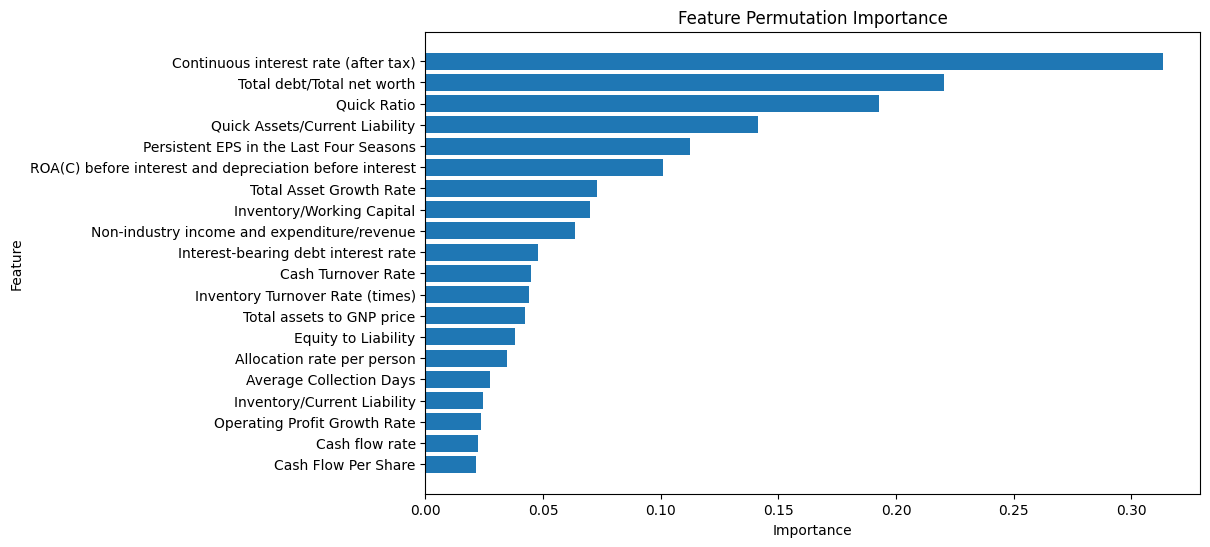

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Current Liability
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Quick Assets/Current Liability']

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Quick Ratio', 'Quick Assets/Current Liability', 'Persistent EPS in the Last Four Seasons']

--- NE

In [ ]:
dt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   24  1247  73  20      24.74   54.55        94.47     93.18     34.04   
1    4  1293  27  40      12.90    9.09        97.95     95.09     10.67   
2    4  1293  27  40      12.90    9.09        97.95     95.09     10.67   
3    3  1296  24  41      11.11    6.82        98.18     95.23      8.45   
4    3  1296  24  41      11.11    6.82        98.18     95.23      8.45   
5    3  1296  24  41      11.11    6.82        98.18     95.23      8.45   
6    3  1296  24  41      11.11    6.82        98.18     95.23      8.45   
7    3  1296  24  41      11.11    6.82        98.18     95.23      8.45   
8    1  1303  17  43       5.56    2.27        98.71     95.60      3.23   
9    1  1303  17  43       5.56    2.27        98.71     95.60      3.23   
10   0  1314   6  44       0.00    0.00        99.55     96.33      0.00   
11   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320   0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               74.51                 0   
1               53.52                 1   
2               53.52                 2   
3               52.50                 3   
4               52.50                 4   
5               52.50                 5   
6               52.50                 6   
7               52.50                 7   
8               50.49                 8   
9               50.49                 9   
10              49.77                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:06:54.633427

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Grow

In [ ]:
dt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   24  1247  73  20      24.74   54.55        94.47     93.18     34.04   
1   24  1250  70  20      25.53   54.55        94.70     93.40     34.78   
2   25  1250  70  19      26.32   56.82        94.70     93.48     35.97   
3    6  1275  45  38      11.76   13.64        96.59     93.91     12.63   
4    5  1276  44  39      10.20   11.36        96.67     93.91     10.75   
5    5  1278  42  39      10.64   11.36        96.82     94.06     10.99   
6    5  1278  42  39      10.64   11.36        96.82     94.06     10.99   
7    5  1278  42  39      10.64   11.36        96.82     94.06     10.99   
8    5  1272  48  39       9.43   11.36        96.36     93.62     10.31   
9    5  1272  48  39       9.43   11.36        96.36     93.62     10.31   
10   5  1270  50  39       9.09   11.36        96.21     93.48     10.10   
11   5  1275  45  39      10.00   11.36        96.59     93.84     10.64   
12   6  1276  44  38      12.00   13.64        96.67     93.99     12.77   
13   6  1267  53  38      10.17   13.64        95.98     93.33     11.65   
14   7  1265  55  37      11.29   15.91        95.83     93.26     13.21   
15   7  1264  56  37      11.11   15.91        95.76     93.18     13.08   
16   7  1271  49  37      12.50   15.91        96.29     93.70     14.00   
17   6  1256  64  38       8.57   13.64        95.15     92.52     10.53   
18   4  1260  60  40       6.25    9.09        95.45     92.67      7.41   
19   5  1262  58  39       7.94   11.36        95.61     92.89      9.35   
20   5  1261  59  39       7.81   11.36        95.53     92.82      9.26   

    balanced_accuracy  num_feat_missing  \
0               74.51                 0   
1               74.62                 1   
2               75.76                 2   
3               55.11                 3   
4               54.02                 4   
5               54.09                 5   
6               54.09                 6   
7               54.09                 7   
8               53.86                 8   
9               53.86                 9   
10              53.79                10   
11              53.98                11   
12              55.15                12   
13              54.81                13   
14              55.87                14   
15              55.83                15   
16              56.10                16   
17              54.39                17   
18              52.27                18   
19              53.48                19   
20              53.45                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': [1.0],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.001],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:16:52.764133

Nested Cross-validation Results:
Individual scores: [0.44827586 0.45588235 0.45112782]
Average nested CV score: 0.452 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.452
2025-01-16 13:19:25.526593

Execution time: 2.55 minutes




```
Starting hyperparameter tuning at: 2025-01-16 00:56:22.087682

Nested Cross-validation Results:
Individual scores: [0.46341463 0.39784946 0.39153439]
Average nested CV score: 0.418 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.452
2025-01-16 02:31:20.837849

Execution time: 94.98 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28                            Total Asset Growth Rate    0.049462  0.014382
34                             Interest Expense Ratio    0.044146  0.003125
0   ROA(C) before interest and depreciation before...    0.037454  0.019885
45                       Accounts Receivable Turnover    0.029745  0.004604
52                         Allocation rate per person    0.026245  0.005777
..                                                ...         ...       ...
2   ROA(B) before interest and depreciation after tax   -0.023589  0.003479
42              Net profit before tax/Paid-in capital   -0.026541  0.004498
53                    Working Capital to Total Assets   -0.033328  0.004191
9                Continuous interest rate (after tax)   -0.039475  0.006333
67                  Retained Earnings to Total Assets   -0.047535  0.009677

[90 rows x 3 columns]

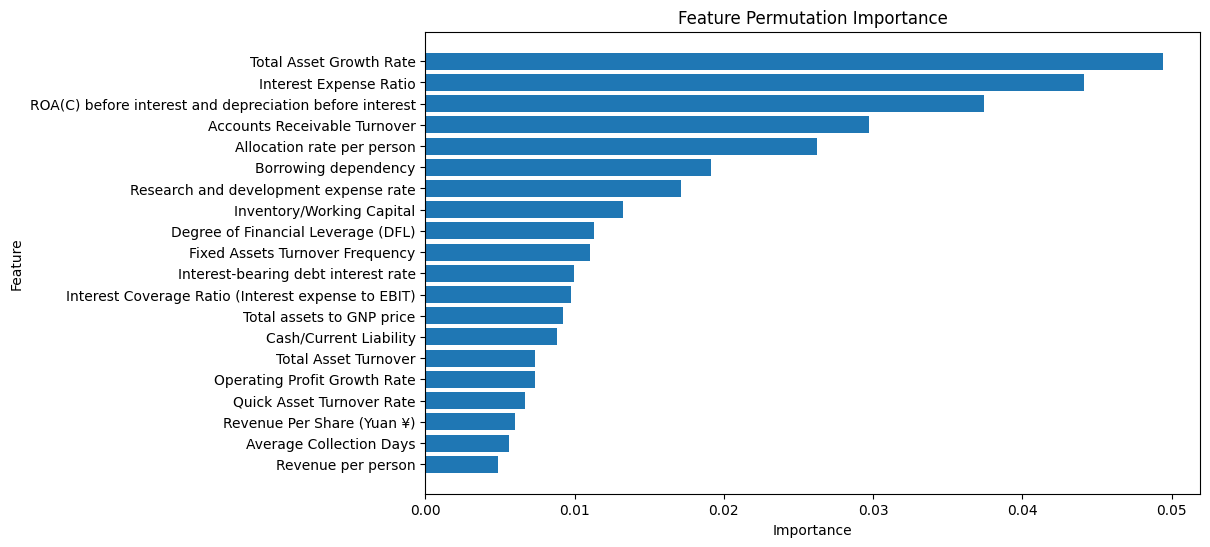

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Total Asset Growth Rate
Original feat removed so far:  ['Total Asset Growth Rate']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Total Asset Growth Rate', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  ROA(C) before interest and depreciation before interest
Original feat removed so far:  ['Total Asset Growth Rate', 'Interest Expense Ratio', 'ROA(C) before interest and depreciation before interest']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Total Asset Growth Rate', 'Interest Expense Ratio', 'ROA(C) before interest and depreciation before interest', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Total Asset Growth Rate', 'Interest Expense Ratio', 'ROA(C) before interest and depreciation before interest', 'Accounts Receivable Tu

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
1   23  1277  43  21      34.85   52.27        96.74     95.31     41.82   
2   23  1277  43  21      34.85   52.27        96.74     95.31     41.82   
3   18  1295  25  26      41.86   40.91        98.11     96.26     41.38   
4   18  1295  25  26      41.86   40.91        98.11     96.26     41.38   
5   18  1295  25  26      41.86   40.91        98.11     96.26     41.38   
6   13  1312   8  31      61.90   29.55        99.39     97.14     40.00   
7   13  1312   8  31      61.90   29.55        99.39     97.14     40.00   
8   13  1311   9  31      59.09   29.55        99.32     97.07     39.39   
9   14  1311   9  30      60.87   31.82        99.32     97.14     41.79   
10  14  1309  11  30      56.00   31.82        99.17     96.99     40.58   
11  15  1309  11  29      57.69   34.09        99.17     97.07     42.86   
12  14  1309  11  30      56.00   31.82        99.17     96.99     40.58   
13  17  1308  12  27      58.62   38.64        99.09     97.14     46.58   
14  16  1311   9  28      64.00   36.36        99.32     97.29     46.38   
15  16  1312   8  28      66.67   36.36        99.39     97.36     47.06   
16  16  1310  10  28      61.54   36.36        99.24     97.21     45.71   
17  16  1308  12  28      57.14   36.36        99.09     97.07     44.44   
18  16  1308  12  28      57.14   36.36        99.09     97.07     44.44   
19  16  1308  12  28      57.14   36.36        99.09     97.07     44.44   
20  17  1306  14  27      54.84   38.64        98.94     96.99     45.33   

    balanced_accuracy  num_feat_missing  \
0               74.66                 0   
1               74.51                 1   
2               74.51                 2   
3               69.51                 3   
4               69.51                 4   
5               69.51                 5   
6               64.47                 6   
7               64.47                 7   
8               64.43                 8   
9               65.57                 9   
10              65.49                10   
11              66.63                11   
12              65.49                12   
13              68.86                13   
14              67.84                14   
15              67.88                15   
16              67.80                16   
17              67.73                17   
18              67.73                18   
19              67.73                19   
20              68.79                20   

                                              imputed  
0                                                      
1                 ['Total Asset Growth Rate'] imputed  
2   ['Total Asset Growth Rate', 'Interest Expense ...  
3   ['Total Asset Growth Rate', 'Interest Expense ...  
4   ['Total Asset Growth Rate', 'Interest Expense ...  
5   ['Total Asset Growth Rate', 'Interest Expense ...  
6   ['Total Asset Growth Rate', 'Interest Expense ...  
7   ['Total Asset Growth Rate', 'Interest Expense ...  
8   ['Total Asset Growth Rate', 'Interest Expense ...  
9   ['Total Asset Growth Rate', 'Interest Expense ...  
10  ['Total Asset Growth Rate', 'Interest Expense ...  
11  ['Total Asset Growth Rate', 'Interest Expense ...  
12  ['Total Asset Growth Rate', 'Interest Expense ...  
13  ['Total Asset Growth Rate', 'Interest Expense ...  
14  ['Total Asset Growth Rate', 'Interest Expense ...  
15  ['Total Asset Growth Rate', 'Interest Expense ...  
16  ['Total Asset Growth Rate', 'Interest Expense ...  
17  ['Total Asset Growth Rate', 'Interest Expense ...  
18  ['Total Asset Growth Rate', 'Interest Expense ...  
19  ['Total Asset Growth Rate', 'Interest Expense ...  
20  ['Total Asset Growth Rate', 'Interest Expense ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:20:27.141290

--- NEW ITERATION ---
Removing feature:  Total Asset Growth Rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Af

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
1   24  1277  43  20      35.82   54.55        96.74     95.38     43.24   
2   24  1277  43  20      35.82   54.55        96.74     95.38     43.24   
3   24  1276  44  20      35.29   54.55        96.67     95.31     42.86   
4   24  1277  43  20      35.82   54.55        96.74     95.38     43.24   
5   24  1276  44  20      35.29   54.55        96.67     95.31     42.86   
6   23  1276  44  21      34.33   52.27        96.67     95.23     41.44   
7   26  1275  45  18      36.62   59.09        96.59     95.38     45.22   
8   24  1273  47  20      33.80   54.55        96.44     95.09     41.74   
9   24  1273  47  20      33.80   54.55        96.44     95.09     41.74   
10  25  1271  49  19      33.78   56.82        96.29     95.01     42.37   
11  25  1272  48  19      34.25   56.82        96.36     95.09     42.74   
12  25  1272  48  19      34.25   56.82        96.36     95.09     42.74   
13  25  1270  50  19      33.33   56.82        96.21     94.94     42.02   
14  24  1270  50  20      32.43   54.55        96.21     94.87     40.68   
15  24  1269  51  20      32.00   54.55        96.14     94.79     40.34   
16  24  1268  52  20      31.58   54.55        96.06     94.72     40.00   
17  25  1268  52  19      32.47   56.82        96.06     94.79     41.32   
18  25  1269  51  19      32.89   56.82        96.14     94.87     41.67   
19  25  1268  52  19      32.47   56.82        96.06     94.79     41.32   
20  24  1267  53  20      31.17   54.55        95.98     94.65     39.67   

    balanced_accuracy  num_feat_missing  \
0               74.66                 0   
1               75.64                 1   
2               75.64                 2   
3               75.61                 3   
4               75.64                 4   
5               75.61                 5   
6               74.47                 6   
7               77.84                 7   
8               75.49                 8   
9               75.49                 9   
10              76.55                10   
11              76.59                11   
12              76.59                12   
13              76.52                13   
14              75.38                14   
15              75.34                15   
16              75.30                16   
17              76.44                17   
18              76.48                18   
19              76.44                19   
20              75.27                20   

                                              imputed  
0                                                      
1                 ['Total Asset Growth Rate'] imputed  
2   ['Total Asset Growth Rate', 'Interest Expense ...  
3   ['Total Asset Growth Rate', 'Interest Expense ...  
4   ['Total Asset Growth Rate', 'Interest Expense ...  
5   ['Total Asset Growth Rate', 'Interest Expense ...  
6   ['Total Asset Growth Rate', 'Interest Expense ...  
7   ['Total Asset Growth Rate', 'Interest Expense ...  
8   ['Total Asset Growth Rate', 'Interest Expense ...  
9   ['Total Asset Growth Rate', 'Interest Expense ...  
10  ['Total Asset Growth Rate', 'Interest Expense ...  
11  ['Total Asset Growth Rate', 'Interest Expense ...  
12  ['Total Asset Growth Rate', 'Interest Expense ...  
13  ['Total Asset Growth Rate', 'Interest Expense ...  
14  ['Total Asset Growth Rate', 'Interest Expense ...  
15  ['Total Asset Growth Rate', 'Interest Expense ...  
16  ['Total Asset Growth Rate', 'Interest Expense ...  
17  ['Total Asset Growth Rate', 'Interest Expense ...  
18  ['Total Asset Growth Rate', 'Interest Expense ...  
19  ['Total Asset Growth Rate', 'Interest Expense ...  
20  ['Total Asset Growth Rate', 'Interest Expense ...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'min_child_samples': [15],
      'min_split_gain': [0.5],
      'reg_lambda': [10.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:30:17.755205

Nested Cross-validation Results:
Individual scores: [0.51666667 0.48695652 0.50793651]
Average nested CV score: 0.504 (+/- 0.025)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.504
2025-01-16 13:30:22.757612

Execution time: 0.08 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:45:25.425769

Nested Cross-validation Results:
Individual scores: [0.48571429 0.46357616 0.49655172]
Average nested CV score: 0.482 (+/- 0.027)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.502

2025-01-13 02:54:28.499933

Execution time: 9.05 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 16:01:24.912059

Nested Cross-validation Results:
Individual scores: [0.45588235 0.43103448 0.49612403]
Average nested CV score: 0.461 (+/- 0.054)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.504

2025-01-15 16:11:33.389958

Execution time: 10.14 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
85                         Net Income to Total Assets    0.089283  0.022345
13                Interest-bearing debt interest rate    0.048650  0.004764
71                          Quick Asset Turnover Rate    0.034922  0.006334
35                         Total debt/Total net worth    0.026502  0.006969
11              Research and development expense rate    0.020947  0.004219
..                                                ...         ...       ...
14                                       Tax rate (A)   -0.006081  0.001114
65                         Current Liabilities/Equity   -0.007204  0.003345
0   ROA(C) before interest and depreciation before...   -0.009448  0.004541
22           Per Share Net profit before tax (Yuan ¥)   -0.010021  0.005748
18            Persistent EPS in the Last Four Seasons   -0.010553  0.002101

[82 rows x 3 columns]

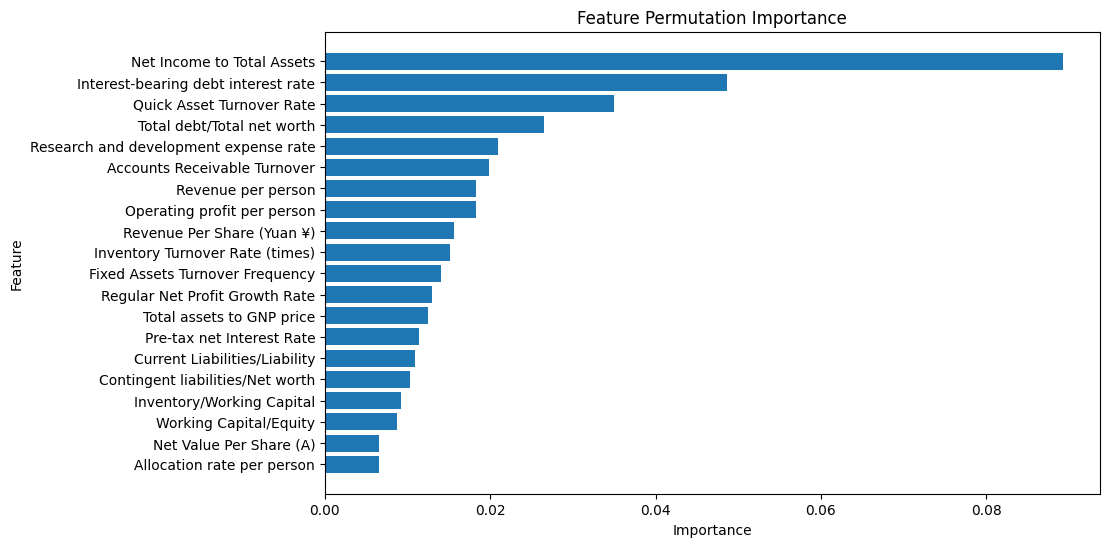

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Net Income to Total Assets', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Net Income to Total Assets', 'Interest-bearing debt interest rate', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Net Income to Total Assets', 'Interest-bearing debt interest rate', 'Quick Asset Turnover Rate', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Research and development expense rate
Original feat removed so far:  ['Net Income to Total Assets', 'Interest-bearing debt interest rate', 'Quick Asset Turnover Rate', 'Total debt/Total net worth', 'Research and developme

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
1    8  1316   4  36      66.67   18.18        99.70     97.07     28.57   
2    3  1318   2  41      60.00    6.82        99.85     96.85     12.24   
3    3  1318   2  41      60.00    6.82        99.85     96.85     12.24   
4    0  1319   1  44       0.00    0.00        99.92     96.70      0.00   
5    0  1318   2  44       0.00    0.00        99.85     96.63      0.00   
6    0  1318   2  44       0.00    0.00        99.85     96.63      0.00   
7    1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
8    1  1318   2  43      33.33    2.27        99.85     96.70      4.26   
9    2  1318   2  42      50.00    4.55        99.85     96.77      8.33   
10   2  1318   2  42      50.00    4.55        99.85     96.77      8.33   
11   2  1318   2  42      50.00    4.55        99.85     96.77      8.33   
12   2  1318   2  42      50.00    4.55        99.85     96.77      8.33   
13   2  1317   3  42      40.00    4.55        99.77     96.70      8.16   
14   3  1317   3  41      50.00    6.82        99.77     96.77     12.00   
15   4  1318   2  40      66.67    9.09        99.85     96.92     16.00   
16   4  1318   2  40      66.67    9.09        99.85     96.92     16.00   
17   6  1318   2  38      75.00   13.64        99.85     97.07     23.08   
18   6  1318   2  38      75.00   13.64        99.85     97.07     23.08   
19   2  1319   1  42      66.67    4.55        99.92     96.85      8.51   
20   2  1319   1  42      66.67    4.55        99.92     96.85      8.51   

    balanced_accuracy  num_feat_missing  \
0               75.23                 0   
1               58.94                 1   
2               53.33                 2   
3               53.33                 3   
4               49.96                 4   
5               49.92                 5   
6               49.92                 6   
7               51.06                 7   
8               51.06                 8   
9               52.20                 9   
10              52.20                10   
11              52.20                11   
12              52.20                12   
13              52.16                13   
14              53.30                14   
15              54.47                15   
16              54.47                16   
17              56.74                17   
18              56.74                18   
19              52.23                19   
20              52.23                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Interest-beari...  
3   ['Net Income to Total Assets', 'Interest-beari...  
4   ['Net Income to Total Assets', 'Interest-beari...  
5   ['Net Income to Total Assets', 'Interest-beari...  
6   ['Net Income to Total Assets', 'Interest-beari...  
7   ['Net Income to Total Assets', 'Interest-beari...  
8   ['Net Income to Total Assets', 'Interest-beari...  
9   ['Net Income to Total Assets', 'Interest-beari...  
10  ['Net Income to Total Assets', 'Interest-beari...  
11  ['Net Income to Total Assets', 'Interest-beari...  
12  ['Net Income to Total Assets', 'Interest-beari...  
13  ['Net Income to Total Assets', 'Interest-beari...  
14  ['Net Income to Total Assets', 'Interest-beari...  
15  ['Net Income to Total Assets', 'Interest-beari...  
16  ['Net Income to Total Assets', 'Interest-beari...  
17  ['Net Income to Total Assets', 'Interest-beari...  
18  ['Net Income to Total Assets', 'Interest-beari...  
19  ['Net Income to Total Assets', 'Interest-beari...  
20  ['Net Income to Total Assets', 'Interest-beari...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:30:28.390382

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
1   23  1296  24  21      48.94   52.27        98.18     96.70     50.55   
2   23  1292  28  21      45.10   52.27        97.88     96.41     48.42   
3   23  1291  29  21      44.23   52.27        97.80     96.33     47.92   
4   23  1291  29  21      44.23   52.27        97.80     96.33     47.92   
5   23  1284  36  21      38.98   52.27        97.27     95.82     44.66   
6   23  1287  33  21      41.07   52.27        97.50     96.04     46.00   
7   24  1283  37  20      39.34   54.55        97.20     95.82     45.71   
8   23  1284  36  21      38.98   52.27        97.27     95.82     44.66   
9   23  1286  34  21      40.35   52.27        97.42     95.97     45.54   
10  23  1286  34  21      40.35   52.27        97.42     95.97     45.54   
11  21  1285  35  23      37.50   47.73        97.35     95.75     42.00   
12  21  1288  32  23      39.62   47.73        97.58     95.97     43.30   
13  23  1281  39  21      37.10   52.27        97.05     95.60     43.40   
14  23  1280  40  21      36.51   52.27        96.97     95.53     42.99   
15  22  1280  40  22      35.48   50.00        96.97     95.45     41.51   
16  24  1276  44  20      35.29   54.55        96.67     95.31     42.86   
17  24  1274  46  20      34.29   54.55        96.52     95.16     42.11   
18  24  1274  46  20      34.29   54.55        96.52     95.16     42.11   
19  23  1274  46  21      33.33   52.27        96.52     95.09     40.71   
20  25  1272  48  19      34.25   56.82        96.36     95.09     42.74   

    balanced_accuracy  num_feat_missing  \
0               75.23                 0   
1               75.23                 1   
2               75.08                 2   
3               75.04                 3   
4               75.04                 4   
5               74.77                 5   
6               74.89                 6   
7               75.87                 7   
8               74.77                 8   
9               74.85                 9   
10              74.85                10   
11              72.54                11   
12              72.65                12   
13              74.66                13   
14              74.62                14   
15              73.48                15   
16              75.61                16   
17              75.53                17   
18              75.53                18   
19              74.39                19   
20              76.59                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Interest-beari...  
3   ['Net Income to Total Assets', 'Interest-beari...  
4   ['Net Income to Total Assets', 'Interest-beari...  
5   ['Net Income to Total Assets', 'Interest-beari...  
6   ['Net Income to Total Assets', 'Interest-beari...  
7   ['Net Income to Total Assets', 'Interest-beari...  
8   ['Net Income to Total Assets', 'Interest-beari...  
9   ['Net Income to Total Assets', 'Interest-beari...  
10  ['Net Income to Total Assets', 'Interest-beari...  
11  ['Net Income to Total Assets', 'Interest-beari...  
12  ['Net Income to Total Assets', 'Interest-beari...  
13  ['Net Income to Total Assets', 'Interest-beari...  
14  ['Net Income to Total Assets', 'Interest-beari...  
15  ['Net Income to Total Assets', 'Interest-beari...  
16  ['Net Income to Total Assets', 'Interest-beari...  
17  ['Net Income to Total Assets', 'Interest-beari...  
18  ['Net Income to Total Assets', 'Interest-beari...  
19  ['Net Income to Total Assets', 'Interest-beari...  
20  ['Net Income to Total Assets', 'Interest-beari...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'reg_lambda':[10.0],
      'gamma': [0.5],
      'colsample_bytree':[0.25]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:40:20.845965

Nested Cross-validation Results:
Individual scores: [0.53333333 0.48333333 0.50819672]
Average nested CV score: 0.508 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.5, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.508
2025-01-16 13:40:25.213829

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:01:40.431570

Nested Cross-validation Results:
Individual scores: [0.40449438 0.35443038 0.38202247]
Average nested CV score: 0.380 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.444

2025-01-13 02:23:36.824783

Execution time: 21.94 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 16:11:33.408575

Nested Cross-validation Results:
Individual scores: [0.3877551  0.47058824 0.48      ]
Average nested CV score: 0.446 (+/- 0.083)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.5, 'max_depth': None, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.508

2025-01-15 16:38:04.249867

Execution time: 26.51 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13                Interest-bearing debt interest rate    0.018908  0.006534
50                                 Revenue per person    0.007891  0.001120
79                          Cash Flow to Total Assets    0.005643  0.002512
61                          Inventory/Working Capital    0.005086  0.001127
71                          Quick Asset Turnover Rate    0.005080  0.002762
8         Non-industry income and expenditure/revenue    0.005074  0.003726
46                            Average Collection Days    0.004520  0.002248
75                             Fixed Assets to Assets    0.003956  0.002259
29                              Net Value Growth Rate    0.003393  0.002113
48                    Fixed Assets Turnover Frequency    0.002833  0.000000
64                             Working Capital/Equity    0.002833  0.000000
58                             Cash/Current Liability    0.002833  0.000000
32                                      Current Ratio    0.002833  0.000000
20                         Revenue Per Share (Yuan ¥)    0.002830  0.001787
65                         Current Liabilities/Equity    0.002266  0.001133
30               Total Asset Return Growth Rate Ratio    0.002266  0.001133
1              ROA(A) before interest and % after tax    0.001700  0.001388
24                       Operating Profit Growth Rate    0.001700  0.001388
47                    Inventory Turnover Rate (times)    0.001700  0.001388
27                  Continuous Net Profit Growth Rate    0.001700  0.001388
19                                Cash Flow Per Share    0.001700  0.001388
70                        Current Asset Turnover Rate    0.001133  0.001388
91                 Degree of Financial Leverage (DFL)    0.001133  0.001388
10                             Operating Expense Rate    0.001133  0.001388
39                               Borrowing dependency    0.001133  0.001388
34                             Interest Expense Ratio    0.001133  0.001388
4                         Realized Sales Gross Margin    0.001133  0.001388
55                        Current Assets/Total Assets    0.001133  0.001388
12                                     Cash flow rate    0.000567  0.001133
43        Inventory and accounts receivable/Net value    0.000567  0.001133
82                                Cash Flow to Equity    0.000567  0.001133
42              Net profit before tax/Paid-in capital    0.000567  0.001133
60                       Operating Funds to Liability    0.000567  0.001133
92  Interest Coverage Ratio (Interest expense to E...    0.000567  0.001133
56                                  Cash/Total Assets    0.000567  0.001133
11              Research and development expense rate    0.000567  0.001133
54                          Quick Assets/Total Assets    0.000567  0.001133
52                         Allocation rate per person    0.000567  0.001133
81                                      CFO to Assets    0.000567  0.001133

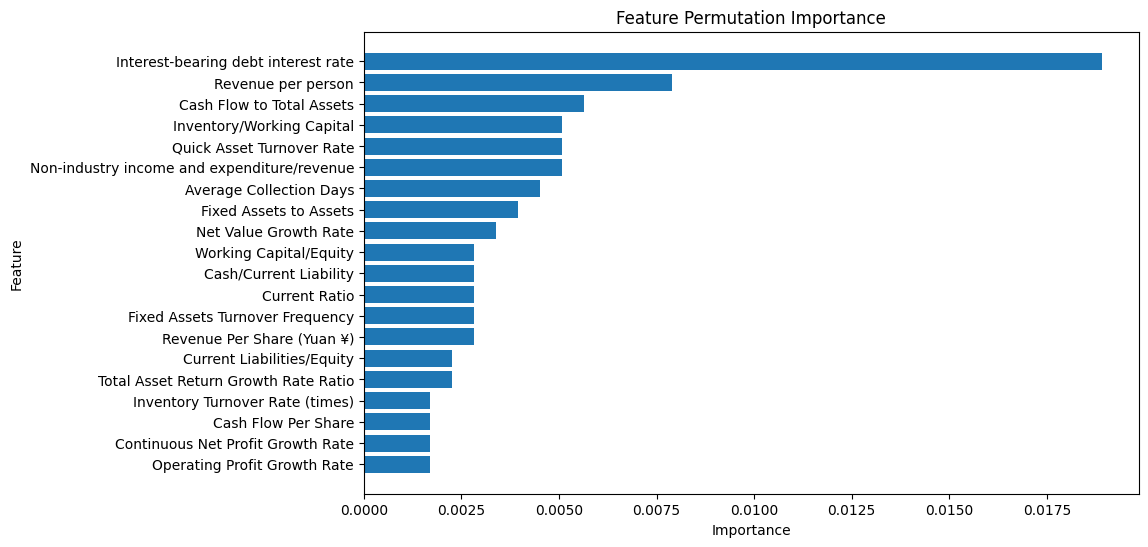

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Total Assets
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash Flow to Total Assets']

--- NEW ITERATION ---
Removing feature:  Inventory/Working Capital
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash Flow to Total Assets', 'Inventory/Working Capital']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Revenue per person', 'Cash Flow to Total Assets', 'Inventory/Working Capital', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1305  15  25      55.88   43.18        98.86     97.07     48.72   
1   18  1308  12  26      60.00   40.91        99.09     97.21     48.65   
2   18  1307  13  26      58.06   40.91        99.02     97.14     48.00   
3   17  1307  13  27      56.67   38.64        99.02     97.07     45.95   
4   17  1307  13  27      56.67   38.64        99.02     97.07     45.95   
5   16  1306  14  28      53.33   36.36        98.94     96.92     43.24   
6   13  1312   8  31      61.90   29.55        99.39     97.14     40.00   
7   14  1310  10  30      58.33   31.82        99.24     97.07     41.18   
8   10  1311   9  34      52.63   22.73        99.32     96.85     31.75   
9    5  1318   2  39      71.43   11.36        99.85     96.99     19.61   
10   6  1318   2  38      75.00   13.64        99.85     97.07     23.08   
11   5  1317   3  39      62.50   11.36        99.77     96.92     19.23   
12   7  1317   3  37      70.00   15.91        99.77     97.07     25.93   
13   5  1317   3  39      62.50   11.36        99.77     96.92     19.23   
14   9  1316   4  35      69.23   20.45        99.70     97.14     31.58   
15   9  1316   4  35      69.23   20.45        99.70     97.14     31.58   
16   9  1316   4  35      69.23   20.45        99.70     97.14     31.58   
17   9  1316   4  35      69.23   20.45        99.70     97.14     31.58   
18  10  1316   4  34      71.43   22.73        99.70     97.21     34.48   
19  10  1316   4  34      71.43   22.73        99.70     97.21     34.48   
20  10  1317   3  34      76.92   22.73        99.77     97.29     35.09   

    balanced_accuracy  num_feat_missing  \
0               71.02                 0   
1               70.00                 1   
2               69.96                 2   
3               68.83                 3   
4               68.83                 4   
5               67.65                 5   
6               64.47                 6   
7               65.53                 7   
8               61.02                 8   
9               55.61                 9   
10              56.74                10   
11              55.57                11   
12              57.84                12   
13              55.57                13   
14              60.08                14   
15              60.08                15   
16              60.08                16   
17              60.08                17   
18              61.21                18   
19              61.21                19   
20              61.25                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:40:30.922152

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growt

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   19  1305  15  25      55.88   43.18        98.86     97.07     48.72   
1   17  1300  20  27      45.95   38.64        98.48     96.55     41.98   
2   17  1299  21  27      44.74   38.64        98.41     96.48     41.46   
3   20  1298  22  24      47.62   45.45        98.33     96.63     46.51   
4   19  1298  22  25      46.34   43.18        98.33     96.55     44.71   
5   20  1296  24  24      45.45   45.45        98.18     96.48     45.45   
6   20  1296  24  24      45.45   45.45        98.18     96.48     45.45   
7   21  1294  26  23      44.68   47.73        98.03     96.41     46.15   
8   20  1295  25  24      44.44   45.45        98.11     96.41     44.94   
9   18  1297  23  26      43.90   40.91        98.26     96.41     42.35   
10  19  1293  27  25      41.30   43.18        97.95     96.19     42.22   
11  20  1292  28  24      41.67   45.45        97.88     96.19     43.48   
12  20  1290  30  24      40.00   45.45        97.73     96.04     42.55   
13  19  1289  31  25      38.00   43.18        97.65     95.89     40.43   
14  19  1288  32  25      37.25   43.18        97.58     95.82     40.00   
15  20  1289  31  24      39.22   45.45        97.65     95.97     42.11   
16  20  1290  30  24      40.00   45.45        97.73     96.04     42.55   
17  20  1288  32  24      38.46   45.45        97.58     95.89     41.67   
18  20  1286  34  24      37.04   45.45        97.42     95.75     40.82   
19  20  1286  34  24      37.04   45.45        97.42     95.75     40.82   
20  20  1287  33  24      37.74   45.45        97.50     95.82     41.24   

    balanced_accuracy  num_feat_missing  \
0               71.02                 0   
1               68.56                 1   
2               68.52                 2   
3               71.89                 3   
4               70.76                 4   
5               71.82                 5   
6               71.82                 6   
7               72.88                 7   
8               71.78                 8   
9               69.58                 9   
10              70.57                10   
11              71.67                11   
12              71.59                12   
13              70.42                13   
14              70.38                14   
15              71.55                15   
16              71.59                16   
17              71.52                17   
18              71.44                18   
19              71.44                19   
20              71.48                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Reven...  
3   ['Interest-bearing debt interest rate', 'Reven...  
4   ['Interest-bearing debt interest rate', 'Reven...  
5   ['Interest-bearing debt interest rate', 'Reven...  
6   ['Interest-bearing debt interest rate', 'Reven...  
7   ['Interest-bearing debt interest rate', 'Reven...  
8   ['Interest-bearing debt interest rate', 'Reven...  
9   ['Interest-bearing debt interest rate', 'Reven...  
10  ['Interest-bearing debt interest rate', 'Reven...  
11  ['Interest-bearing debt interest rate', 'Reven...  
12  ['Interest-bearing debt interest rate', 'Reven...  
13  ['Interest-bearing debt interest rate', 'Reven...  
14  ['Interest-bearing debt interest rate', 'Reven...  
15  ['Interest-bearing debt interest rate', 'Reven...  
16  ['Interest-bearing debt interest rate', 'Reven...  
17  ['Interest-bearing debt interest rate', 'Reven...  
18  ['Interest-bearing debt interest rate', 'Reven...  
19  ['Interest-bearing debt interest rate', 'Reven...  
20  ['Interest-bearing debt interest rate', 'Reven...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [300],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 13:50:21.412702

Nested Cross-validation Results:
Individual scores: [0.48275862 0.47692308 0.43708609]
Average nested CV score: 0.466 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.466
2025-01-16 13:50:33.744789

Execution time: 0.21 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:38:04.263173

Nested Cross-validation Results:
Individual scores: [0.43274854 0.44585987 0.42222222]
Average nested CV score: 0.434 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.466

2025-01-15 16:59:30.550623

Execution time: 21.44 minutes
```



In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
47                    Inventory Turnover Rate (times)    0.004722  0.000741
71                          Quick Asset Turnover Rate    0.003073  0.001767
50                                 Revenue per person    0.002840  0.001202
63                      Current Liabilities/Liability    0.002603  0.001379
70                        Current Asset Turnover Rate    0.002368  0.001291
..                                                ...         ...       ...
0   ROA(C) before interest and depreciation before...   -0.041278  0.004569
93                                Equity to Liability   -0.041808  0.003813
42              Net profit before tax/Paid-in capital   -0.044818  0.006025
36                                       Debt ratio %   -0.057810  0.004042
37                                   Net worth/Assets   -0.063204  0.002946

[91 rows x 3 columns]

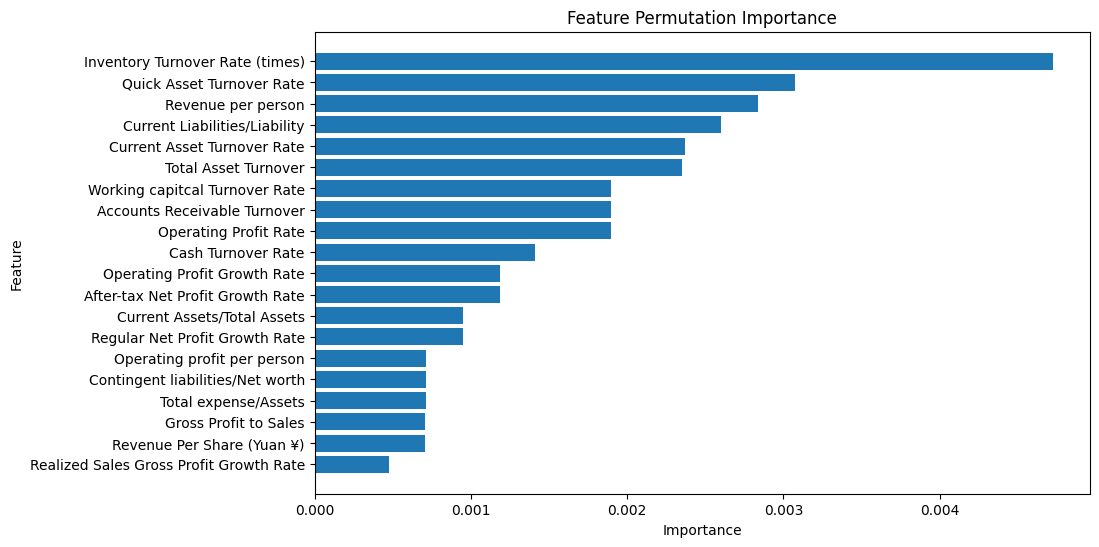

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Quick Asset Turnover Rate', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Liability
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Quick Asset Turnover Rate', 'Revenue per person', 'Current Liabilities/Liability']

--- NEW ITERATION ---
Removing feature:  Current Asset Turnover Rate
Original feat removed so far:  ['Inventory Turnover Rate (times)', 'Quick Asset Turnover Rate', 'Revenue per person', 'Current Liabilities/Liability', 'Current Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature: 

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1265  55  17      32.93   61.36        95.83     94.72     42.86   
1   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
2   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
3   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
4   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
5   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
6   29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
7   29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
8   29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
9   29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
10  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
11  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
12  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
13  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
14  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
15  28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
16  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
17  28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
18  28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
19  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
20  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   

    balanced_accuracy  num_feat_missing  \
0               78.60                 0   
1               79.73                 1   
2               79.73                 2   
3               79.73                 3   
4               80.87                 4   
5               80.87                 5   
6               80.83                 6   
7               80.83                 7   
8               80.83                 8   
9               80.83                 9   
10              79.70                10   
11              79.70                11   
12              79.70                12   
13              80.83                13   
14              80.83                14   
15              79.66                15   
16              79.70                16   
17              79.73                17   
18              79.73                18   
19              80.87                19   
20              80.87                20   

                                              imputed  
0                                                      
1         ['Inventory Turnover Rate (times)'] imputed  
2   ['Inventory Turnover Rate (times)', 'Quick Ass...  
3   ['Inventory Turnover Rate (times)', 'Quick Ass...  
4   ['Inventory Turnover Rate (times)', 'Quick Ass...  
5   ['Inventory Turnover Rate (times)', 'Quick Ass...  
6   ['Inventory Turnover Rate (times)', 'Quick Ass...  
7   ['Inventory Turnover Rate (times)', 'Quick Ass...  
8   ['Inventory Turnover Rate (times)', 'Quick Ass...  
9   ['Inventory Turnover Rate (times)', 'Quick Ass...  
10  ['Inventory Turnover Rate (times)', 'Quick Ass...  
11  ['Inventory Turnover Rate (times)', 'Quick Ass...  
12  ['Inventory Turnover Rate (times)', 'Quick Ass...  
13  ['Inventory Turnover Rate (times)', 'Quick Ass...  
14  ['Inventory Turnover Rate (times)', 'Quick Ass...  
15  ['Inventory Turnover Rate (times)', 'Quick Ass...  
16  ['Inventory Turnover Rate (times)', 'Quick Ass...  
17  ['Inventory Turnover Rate (times)', 'Quick Ass...  
18  ['Inventory Turnover Rate (times)', 'Quick Ass...  
19  ['Inventory Turnover Rate (times)', 'Quick Ass...  
20  ['Inventory Turnover Rate (times)', 'Quick Ass...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 13:50:48.603734

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Ra

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1265  55  17      32.93   61.36        95.83     94.72     42.86   
1   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
2   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
3   28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
4   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
5   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
6   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
7   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
8   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
9   29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
10  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
11  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
12  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
13  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
14  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
15  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
16  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
17  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
18  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
19  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   
20  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   

    balanced_accuracy  num_feat_missing  \
0               78.60                 0   
1               79.73                 1   
2               79.73                 2   
3               79.73                 3   
4               80.87                 4   
5               80.87                 5   
6               80.87                 6   
7               80.87                 7   
8               80.87                 8   
9               80.87                 9   
10              80.87                10   
11              80.87                11   
12              80.91                12   
13              80.91                13   
14              80.87                14   
15              80.91                15   
16              80.91                16   
17              80.83                17   
18              80.83                18   
19              80.83                19   
20              80.83                20   

                                              imputed  
0                                                      
1         ['Inventory Turnover Rate (times)'] imputed  
2   ['Inventory Turnover Rate (times)', 'Quick Ass...  
3   ['Inventory Turnover Rate (times)', 'Quick Ass...  
4   ['Inventory Turnover Rate (times)', 'Quick Ass...  
5   ['Inventory Turnover Rate (times)', 'Quick Ass...  
6   ['Inventory Turnover Rate (times)', 'Quick Ass...  
7   ['Inventory Turnover Rate (times)', 'Quick Ass...  
8   ['Inventory Turnover Rate (times)', 'Quick Ass...  
9   ['Inventory Turnover Rate (times)', 'Quick Ass...  
10  ['Inventory Turnover Rate (times)', 'Quick Ass...  
11  ['Inventory Turnover Rate (times)', 'Quick Ass...  
12  ['Inventory Turnover Rate (times)', 'Quick Ass...  
13  ['Inventory Turnover Rate (times)', 'Quick Ass...  
14  ['Inventory Turnover Rate (times)', 'Quick Ass...  
15  ['Inventory Turnover Rate (times)', 'Quick Ass...  
16  ['Inventory Turnover Rate (times)', 'Quick Ass...  
17  ['Inventory Turnover Rate (times)', 'Quick Ass...  
18  ['Inventory Turnover Rate (times)', 'Quick Ass...  
19  ['Inventory Turnover Rate (times)', 'Quick Ass...  
20  ['Inventory Turnover Rate (times)', 'Quick Ass...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [20],
    'kernel': ['poly'],
    'gamma': [2],
    'degree': [2]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:00:32.338164

Nested Cross-validation Results:
Individual scores: [0.31958763 0.30674847 0.32768362]
Average nested CV score: 0.318 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20, 'degree': 2, 'gamma': 2, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.318
2025-01-16 14:00:48.126322

Execution time: 0.26 minutes




```
Starting hyperparameter tuning at: 2025-01-15 16:59:30.592835

Nested Cross-validation Results:
Individual scores: [0.27058824 0.30601093 0.2970297 ]
Average nested CV score: 0.291 (+/- 0.030)

Fitting final model on entire dataset...
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
Best parameters: {'C': 20, 'degree': 2, 'gamma': 2, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.318

2025-01-15 17:06:18.527668

Execution time: 6.80 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   ROA(C) before interest and depreciation before...    0.469124  0.011956
85                         Net Income to Total Assets    0.336783  0.015410
54                          Quick Assets/Total Assets    0.290469  0.003945
18            Persistent EPS in the Last Four Seasons    0.281314  0.019979
59                        Current Liability to Assets    0.276303  0.019245
..                                                ...         ...       ...
9                Continuous interest rate (after tax)    0.000417  0.001259
40                   Contingent liabilities/Net worth   -0.000633  0.001073
49                    Net Worth Turnover Rate (times)   -0.002492  0.003849
12                                     Cash flow rate   -0.003165  0.006875
64                             Working Capital/Equity   -0.008081  0.005306

[89 rows x 3 columns]

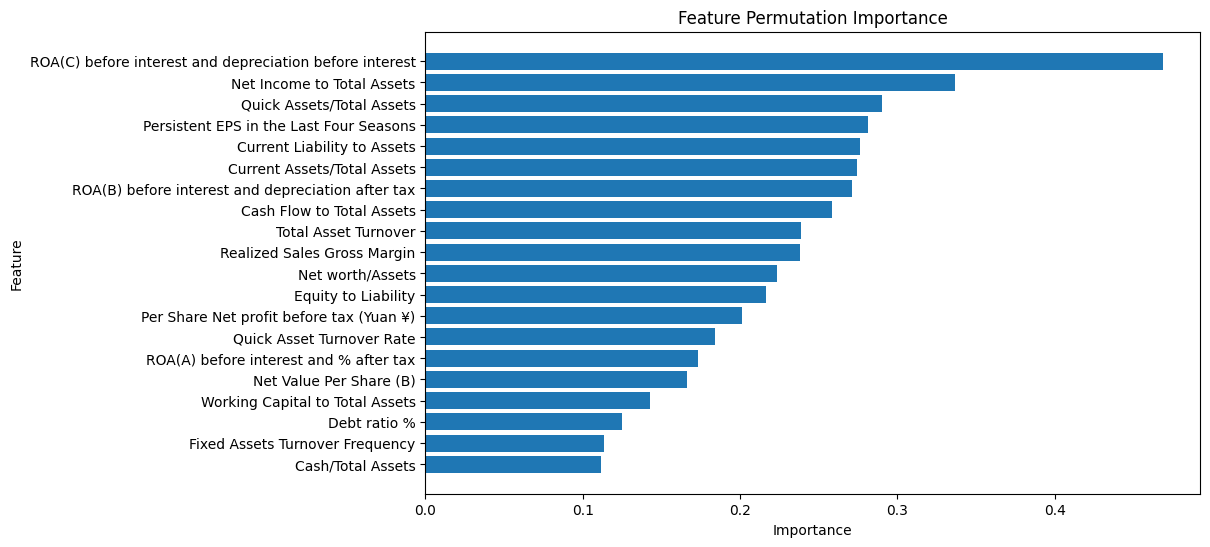

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  ROA(C) before interest and depreciation before interest
Original feat removed so far:  ['ROA(C) before interest and depreciation before interest']

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['ROA(C) before interest and depreciation before interest', 'Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['ROA(C) before interest and depreciation before interest', 'Net Income to Total Assets', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['ROA(C) before interest and depreciation before interest', 'Net Income to Total Assets', 'Quick Assets/Total Assets', 'Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Current Liability to Assets
Original feat removed so far:  ['ROA(C) before interest an

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   20  1243   77  24      20.62   45.45        94.17     92.60     28.37   
1    6  1257   63  38       8.70   13.64        95.23     92.60     10.62   
2    2  1217  103  42       1.90    4.55        92.20     89.37      2.68   
3   11  1119  201  33       5.19   25.00        84.77     82.84      8.59   
4    9  1053  267  35       3.26   20.45        79.77     77.86      5.62   
5    7  1067  253  37       2.69   15.91        80.83     78.74      4.61   
6    4  1078  242  40       1.63    9.09        81.67     79.33      2.76   
7    6  1127  193  38       3.02   13.64        85.38     83.06      4.94   
8    6  1113  207  38       2.82   13.64        84.32     82.04      4.67   
9    3  1123  197  41       1.50    6.82        85.08     82.55      2.46   
10   7  1140  180  37       3.74   15.91        86.36     84.09      6.06   
11  10  1123  197  34       4.83   22.73        85.08     83.06      7.97   
12   8  1103  217  36       3.56   18.18        83.56     81.45      5.95   
13   9  1141  179  35       4.79   20.45        86.44     84.31      7.76   
14   7  1171  149  37       4.49   15.91        88.71     86.36      7.00   
15  11  1171  149  33       6.88   25.00        88.71     86.66     10.78   
16   7  1122  198  37       3.41   15.91        85.00     82.77      5.62   
17   3  1136  184  41       1.60    6.82        86.06     83.50      2.60   
18   5  1135  185  39       2.63   11.36        85.98     83.58      4.27   
19   7  1129  191  37       3.54   15.91        85.53     83.28      5.79   
20   5  1129  191  39       2.55   11.36        85.53     83.14      4.17   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               54.43                 1   
2               48.37                 2   
3               54.89                 3   
4               50.11                 4   
5               48.37                 5   
6               45.38                 6   
7               49.51                 7   
8               48.98                 8   
9               45.95                 9   
10              51.14                10   
11              53.90                11   
12              50.87                12   
13              53.45                13   
14              52.31                14   
15              56.86                15   
16              50.45                16   
17              46.44                17   
18              48.67                18   
19              50.72                19   
20              48.45                20   

                                              imputed  
0                                                      
1   ['ROA(C) before interest and depreciation befo...  
2   ['ROA(C) before interest and depreciation befo...  
3   ['ROA(C) before interest and depreciation befo...  
4   ['ROA(C) before interest and depreciation befo...  
5   ['ROA(C) before interest and depreciation befo...  
6   ['ROA(C) before interest and depreciation befo...  
7   ['ROA(C) before interest and depreciation befo...  
8   ['ROA(C) before interest and depreciation befo...  
9   ['ROA(C) before interest and depreciation befo...  
10  ['ROA(C) before interest and depreciation befo...  
11  ['ROA(C) before interest and depreciation befo...  
12  ['ROA(C) before interest and depreciation befo...  
13  ['ROA(C) before interest and depreciation befo...  
14  ['ROA(C) before interest and depreciation befo...  
15  ['ROA(C) before interest and depreciation befo...  
16  ['ROA(C) before interest and depreciation befo...  
17  ['ROA(C) before interest and depreciation befo...  
18  ['ROA(C) before interest and depreciation befo...  
19  ['ROA(C) before interest and depreciation befo...  
20  ['ROA(C) before interest and depreciation befo...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:01:11.944766

--- NEW ITERATION ---
Removing feature:  ROA(C) before interest and depreciation before interest
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Op

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   20  1243   77  24      20.62   45.45        94.17     92.60     28.37   
1   22  1244   76  22      22.45   50.00        94.24     92.82     30.99   
2   19  1251   69  25      21.59   43.18        94.77     93.11     28.79   
3   24  1236   84  20      22.22   54.55        93.64     92.38     31.58   
4   16  1251   69  28      18.82   36.36        94.77     92.89     24.81   
5   16  1254   66  28      19.51   36.36        95.00     93.11     25.40   
6   21  1236   84  23      20.00   47.73        93.64     92.16     28.19   
7   20  1242   78  24      20.41   45.45        94.09     92.52     28.17   
8   19  1242   78  25      19.59   43.18        94.09     92.45     26.95   
9   14  1259   61  30      18.67   31.82        95.38     93.33     23.53   
10  15  1257   63  29      19.23   34.09        95.23     93.26     24.59   
11  13  1257   63  31      17.11   29.55        95.23     93.11     21.67   
12  13  1256   64  31      16.88   29.55        95.15     93.04     21.49   
13  13  1256   64  31      16.88   29.55        95.15     93.04     21.49   
14  26  1135  185  18      12.32   59.09        85.98     85.12     20.39   
15  26  1125  195  18      11.76   59.09        85.23     84.38     19.62   
16  25  1129  191  19      11.57   56.82        85.53     84.60     19.23   
17  23  1146  174  21      11.68   52.27        86.82     85.70     19.09   
18  24  1126  194  20      11.01   54.55        85.30     84.31     18.32   
19  23  1119  201  21      10.27   52.27        84.77     83.72     17.16   
20  25  1135  185  19      11.90   56.82        85.98     85.04     19.69   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               72.12                 1   
2               68.98                 2   
3               74.09                 3   
4               65.57                 4   
5               65.68                 5   
6               70.68                 6   
7               69.77                 7   
8               68.64                 8   
9               63.60                 9   
10              64.66                10   
11              62.39                11   
12              62.35                12   
13              62.35                13   
14              72.54                14   
15              72.16                15   
16              71.17                16   
17              69.55                17   
18              69.92                18   
19              68.52                19   
20              71.40                20   

                                              imputed  
0                                                      
1   ['ROA(C) before interest and depreciation befo...  
2   ['ROA(C) before interest and depreciation befo...  
3   ['ROA(C) before interest and depreciation befo...  
4   ['ROA(C) before interest and depreciation befo...  
5   ['ROA(C) before interest and depreciation befo...  
6   ['ROA(C) before interest and depreciation befo...  
7   ['ROA(C) before interest and depreciation befo...  
8   ['ROA(C) before interest and depreciation befo...  
9   ['ROA(C) before interest and depreciation befo...  
10  ['ROA(C) before interest and depreciation befo...  
11  ['ROA(C) before interest and depreciation befo...  
12  ['ROA(C) before interest and depreciation befo...  
13  ['ROA(C) before interest and depreciation befo...  
14  ['ROA(C) before interest and depreciation befo...  
15  ['ROA(C) before interest and depreciation befo...  
16  ['ROA(C) before interest and depreciation befo...  
17  ['ROA(C) before interest and depreciation befo...  
18  ['ROA(C) before interest and depreciation befo...  
19  ['ROA(C) before interest and depreciation befo...  
20  ['ROA(C) before interest and depreciation befo...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.9229225242164265
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8659792670788311
eliminated feature:  ROA(A) before interest and % after tax 0.9147228865422486
eliminated feature:  ROA(B) before interest and depreciation after tax 0.8494552594400555
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8358567451256378
eliminated feature:  Net profit before tax/Paid-in capital 0.8684301506246517
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.8648115427624863
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8477243589006391
eliminated feature:  Debt ratio % 0.8091262508475018
eliminated feature:  Net worth/Assets 0.8091262508680306
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liability to Equity
eliminated feature:  Current Liabilities/Equity 1.000000000039116

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  62


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:09:54.513585

Nested Cross-validation Results:
Individual scores: [0.36363636 0.18656716 0.25994695]
Average nested CV score: 0.270 (+/- 0.145)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.270
2025-01-16 14:09:59.198183

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-15 17:06:19.366664

Nested Cross-validation Results:
Individual scores: [0.24309392 0.28143713 0.26911315]
Average nested CV score: 0.265 (+/- 0.032)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.270

2025-01-15 17:08:47.369842

Execution time: 2.47 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
33                          Quick Assets/Total Assets    0.022067  0.003935
22                                  Cash/Total Assets    0.021616  0.007317
23                               Total expense/Assets    0.015060  0.002612
32                               Total Asset Turnover    0.012573  0.004381
44                                 Cash Turnover Rate    0.011031  0.003203
48                     Current Liability to Liability    0.008632  0.003187
50                    Inventory Turnover Rate (times)    0.007313  0.000918
10                                Equity to Liability    0.005359  0.003142
27                                Cash Flow to Equity    0.004760  0.001012
12                              Liability-Assets Flag    0.003986  0.000163
49                          Quick Asset Turnover Rate    0.003595  0.004838
11                        Operating profit per person    0.003212  0.001888
39            Realized Sales Gross Profit Growth Rate    0.002875  0.000288
31                             Cash Flow to Liability    0.002848  0.000737
17                             Operating Gross Margin    0.002429  0.001298
19        Inventory and accounts receivable/Net value    0.002059  0.001203
0                  Net Income to Stockholder's Equity    0.002054  0.001258
45                         Total debt/Total net worth    0.002016  0.000239
46              Research and development expense rate    0.001756  0.003107
54                        Current Asset Turnover Rate    0.001688  0.000568
38                    Fixed Assets Turnover Frequency    0.001591  0.001877
36                            Total Asset Growth Rate    0.001523  0.000655
26                             Cash/Current Liability    0.001483  0.000524
25                                 No-credit Interval    0.001358  0.000696
41               Long-term fund suitability ratio (A)    0.001237  0.000290
55                       Accounts Receivable Turnover    0.000949  0.000670
47                Interest-bearing debt interest rate    0.000890  0.002984
6                              Working Capital/Equity    0.000703  0.000101
24                   After-tax Net Profit Growth Rate    0.000620  0.000000
51                          Total assets to GNP price    0.000616  0.000520
53              Long-term Liability to Current Assets    0.000580  0.000894
16  Interest Coverage Ratio (Interest expense to E...    0.000496  0.000336
9                       Equity to Long-term Liability    0.000481  0.000826
21                                Cash Flow Per Share    0.000472  0.002210
3                         Current Liability to Equity    0.000453  0.001284
1                                Borrowing dependency    0.000347  0.001211
56                            Average Collection Days    0.000331  0.000101
43                                        Quick Ratio    0.000207  0.000131
4                 Current Liability to Current Assets    0.000197  0.003536
28                          Inventory/Working Capital    0.000166  0.000155
20               Total Asset Return Growth Rate Ratio    0.000124  0.000101
37                       Operating Profit Growth Rate    0.000124  0.000310
14                             Interest Expense Ratio    0.000041  0.000083
34                             Fixed Assets to Assets    0.000041  0.000083
8                Continuous interest rate (after tax)    0.000041  0.000155
52                         Allocation rate per person    0.000041  0.000203
61                                      Current Ratio   -0.000041  0.000083
58                         Revenue Per Share (Yuan ¥)   -0.000041  0.000083
42                                 Revenue per person   -0.000080  0.000683
57                        Inventory/Current Liability   -0.000122  0.000495
2                   Retained Earnings to Total Assets   -0.000217  0.002991
30                 Degree of Financial Leverage (DFL)   -0.000249  0.000357
18                

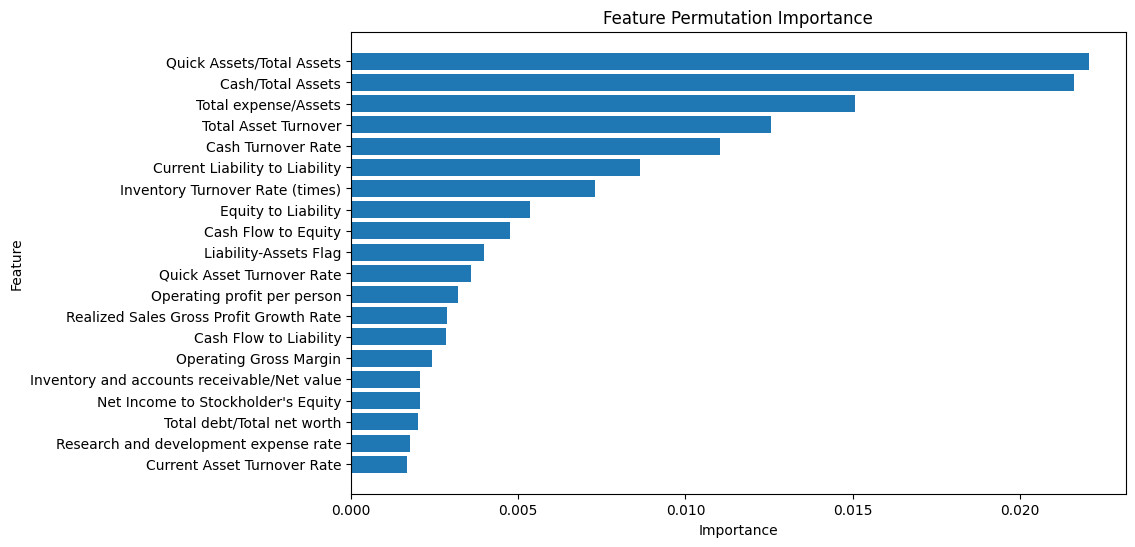

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets', 'Total expense/Assets', 'Total Asset Turnover', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat removed so far:  ['Quick Assets/Total Assets', 'Cash/Total Assets',

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1   38  1077  243   6      13.52   86.36        81.59     81.74     23.38   
2   37  1089  231   7      13.81   84.09        82.50     82.55     23.72   
3   39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
4   39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.66                 0   
1               83.98                 1   
2               83.30                 2   
3               85.91                 3   
4               85.91                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
3   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
4   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
5   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
6   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
7   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
8   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
9   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
10  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
11  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
12  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
13  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
14  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
15  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
16  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
17  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
18  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
19  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
20  ['Quick Assets/Total Assets', 'Cash/Total Asse...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:10:01.618999

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingen

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1   38  1094  226   6      14.39   86.36        82.88     82.99     24.68   
2   39  1110  210   5      15.66   88.64        84.09     84.24     26.62   
3   39  1104  216   5      15.29   88.64        83.64     83.80     26.09   
4   41  1117  203   3      16.80   93.18        84.62     84.90     28.47   
5   37  1104  216   7      14.62   84.09        83.64     83.65     24.92   
6   39  1109  211   5      15.60   88.64        84.02     84.16     26.53   
7   39  1115  205   5      15.98   88.64        84.47     84.60     27.08   
8   39  1116  204   5      16.05   88.64        84.55     84.68     27.18   
9   39  1111  209   5      15.73   88.64        84.17     84.31     26.71   
10  38  1111  209   6      15.38   86.36        84.17     84.24     26.12   
11  37  1121  199   7      15.68   84.09        84.92     84.90     26.43   
12  37  1120  200   7      15.61   84.09        84.85     84.82     26.33   
13  37  1120  200   7      15.61   84.09        84.85     84.82     26.33   
14  37  1113  207   7      15.16   84.09        84.32     84.31     25.69   
15  37  1119  201   7      15.55   84.09        84.77     84.75     26.24   
16  37  1115  205   7      15.29   84.09        84.47     84.46     25.87   
17  37  1117  203   7      15.42   84.09        84.62     84.60     26.06   
18  37  1118  202   7      15.48   84.09        84.70     84.68     26.15   
19  36  1122  198   8      15.38   81.82        85.00     84.90     25.90   
20  38  1106  214   6      15.08   86.36        83.79     83.87     25.68   

    balanced_accuracy  num_feat_missing  \
0               84.66                 0   
1               84.62                 1   
2               86.36                 2   
3               86.14                 3   
4               88.90                 4   
5               83.86                 5   
6               86.33                 6   
7               86.55                 7   
8               86.59                 8   
9               86.40                 9   
10              85.27                10   
11              84.51                11   
12              84.47                12   
13              84.47                13   
14              84.20                14   
15              84.43                15   
16              84.28                16   
17              84.36                17   
18              84.39                18   
19              83.41                19   
20              85.08                20   

                                              imputed  
0                                                      
1               ['Quick Assets/Total Assets'] imputed  
2   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
3   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
4   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
5   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
6   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
7   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
8   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
9   ['Quick Assets/Total Assets', 'Cash/Total Asse...  
10  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
11  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
12  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
13  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
14  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
15  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
16  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
17  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
18  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
19  ['Quick Assets/Total Assets', 'Cash/Total Asse...  
20  ['Quick Assets/Total Assets', 'Cash/Total Asse...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.005]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:14:32.081328

Nested Cross-validation Results:
Individual scores: [0.83324345 0.84798197 0.83566356]
Average nested CV score: 0.839 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.839
2025-01-16 14:14:32.934340

Execution time: 0.01 minutes




```
Starting hyperparameter tuning at: 2025-01-15 17:08:47.377994

Nested Cross-validation Results:
Individual scores: [0.8301666  0.85063676 0.82070418]
Average nested CV score: 0.834 (+/- 0.025)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.839

2025-01-15 17:09:24.729737

Execution time: 0.62 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
9      Continuous interest rate (after tax)    0.245545  0.020559
35               Total debt/Total net worth    0.077651  0.007698
18  Persistent EPS in the Last Four Seasons    0.031967  0.003185
52               Allocation rate per person    0.029070  0.005487
34                   Interest Expense Ratio    0.023711  0.005112
61                Inventory/Working Capital    0.012179  0.001028

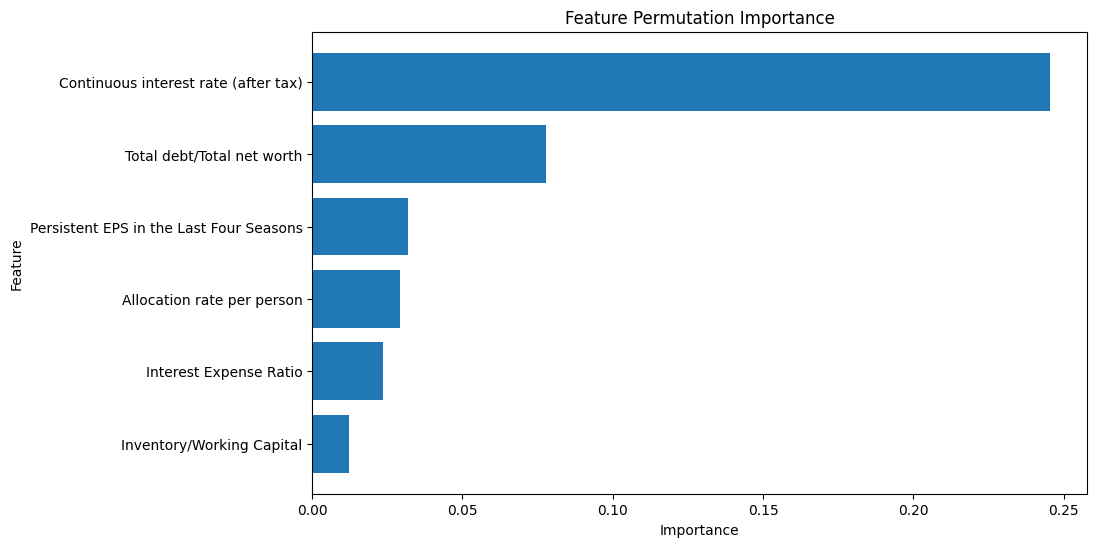

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Original feat removed so far:  ['Continuous interest rate (after tax)']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Persistent EPS in the Last Four Seasons', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Continuous interest rate (after tax)', 'Total debt/Total net worth', 'Persistent EPS in the Last Four Seasons

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1115  205   4      16.33   90.91        84.47     84.68     27.68   
1   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
2   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
3   10  1217  103  34       8.85   22.73        92.20     89.96     12.74   
4    6  1290   30  38      16.67   13.64        97.73     95.01     15.00   
5    9  1281   39  35      18.75   20.45        97.05     94.57     19.57   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               87.69                 0   
1               57.46                 1   
2               57.46                 2   
3               57.46                 3   
4               55.68                 4   
5               58.75                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:14:34.389510

--- NEW ITERATION ---
Removing feature:  Continuous interest rate (after tax)
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Grow

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   40  1115  205   4      16.33   90.91        84.47     84.68     27.68   
1   40  1119  201   4      16.60   90.91        84.77     84.97     28.07   
2   39  1114  206   5      15.92   88.64        84.39     84.53     26.99   
3   37  1105  215   7      14.68   84.09        83.71     83.72     25.00   
4   40  1075  245   4      14.04   90.91        81.44     81.74     24.32   
5   39  1061  259   5      13.09   88.64        80.38     80.65     22.81   
6   39  1043  277   5      12.34   88.64        79.02     79.33     21.67   
7   40  1049  271   4      12.86   90.91        79.47     79.84     22.54   
8   39  1047  273   5      12.50   88.64        79.32     79.62     21.91   
9   39  1050  270   5      12.62   88.64        79.55     79.84     22.10   
10  39  1037  283   5      12.11   88.64        78.56     78.89     21.31   
11  39  1044  276   5      12.38   88.64        79.09     79.40     21.73   
12  39  1039  281   5      12.19   88.64        78.71     79.03     21.43   
13  39  1048  272   5      12.54   88.64        79.39     79.69     21.97   
14  39  1049  271   5      12.58   88.64        79.47     79.77     22.03   
15  38  1052  268   6      12.42   86.36        79.70     79.91     21.71   
16  38  1048  272   6      12.26   86.36        79.39     79.62     21.47   
17  38  1042  278   6      12.03   86.36        78.94     79.18     21.11   
18  36  1043  277   8      11.50   81.82        79.02     79.11     20.17   
19  35  1044  276   9      11.25   79.55        79.09     79.11     19.72   
20  37  1070  250   7      12.89   84.09        81.06     81.16     22.36   

    balanced_accuracy  num_feat_missing  \
0               87.69                 0   
1               87.84                 1   
2               86.52                 2   
3               83.90                 3   
4               86.17                 4   
5               84.51                 5   
6               83.83                 6   
7               85.19                 7   
8               83.98                 8   
9               84.09                 9   
10              83.60                10   
11              83.86                11   
12              83.67                12   
13              84.02                13   
14              84.05                14   
15              83.03                15   
16              82.88                16   
17              82.65                17   
18              80.42                18   
19              79.32                19   
20              82.58                20   

                                              imputed  
0                                                      
1    ['Continuous interest rate (after tax)'] imputed  
2   ['Continuous interest rate (after tax)', 'Tota...  
3   ['Continuous interest rate (after tax)', 'Tota...  
4   ['Continuous interest rate (after tax)', 'Tota...  
5   ['Continuous interest rate (after tax)', 'Tota...  
6   ['Continuous interest rate (after tax)', 'Tota...  
7   ['Continuous interest rate (after tax)', 'Tota...  
8   ['Continuous interest rate (after tax)', 'Tota...  
9   ['Continuous interest rate (after tax)', 'Tota...  
10  ['Continuous interest rate (after tax)', 'Tota...  
11  ['Continuous interest rate (after tax)', 'Tota...  
12  ['Continuous interest rate (after tax)', 'Tota...  
13  ['Continuous interest rate (after tax)', 'Tota...  
14  ['Continuous interest rate (after tax)', 'Tota...  
15  ['Continuous interest rate (after tax)', 'Tota...  
16  ['Continuous interest rate (after tax)', 'Tota...  
17  ['Continuous interest rate (after tax)', 'Tota...  
18  ['Continuous interest rate (after tax)', 'Tota...  
19  ['Continuous interest rate (after tax)', 'Tota...  
20  ['Continuous interest rate (after tax)', 'Tota...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [200],
    'max_features': [0.5],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_depth': [3],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:24:23.803270

Nested Cross-validation Results:
Individual scores: [0.871172   0.86113832 0.83752806]
Average nested CV score: 0.857 (+/- 0.028)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.857
2025-01-16 14:24:57.796350

Execution time: 0.57 minutes



```
Starting hyperparameter tuning at: 2025-01-16 02:31:20.847185

Nested Cross-validation Results:
Individual scores: [0.86785921 0.8588656  0.82848498]
Average nested CV score: 0.852 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.857
2025-01-16 04:02:39.232512

Execution time: 91.31 minutes
```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
18  Persistent EPS in the Last Four Seasons    0.014809  0.002895
52               Allocation rate per person    0.010284  0.001838
39                     Borrowing dependency    0.010113  0.002904
35               Total debt/Total net worth    0.009924  0.004362
46                  Average Collection Days    0.008845  0.002761
..                                      ...         ...       ...
10                   Operating Expense Rate   -0.000057  0.000046
44                     Total Asset Turnover   -0.000057  0.000046
88                    Gross Profit to Sales   -0.000133  0.000046
4               Realized Sales Gross Margin   -0.000322  0.000076
57           Quick Assets/Current Liability   -0.000398  0.000071

[80 rows x 3 columns]

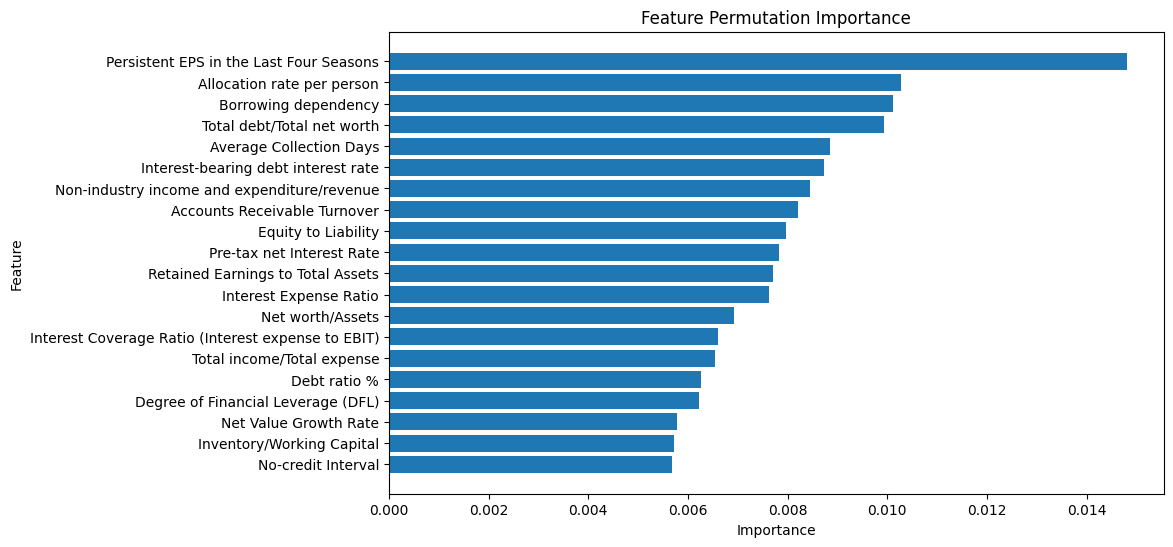

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Allocation rate per person', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Allocation rate per person', 'Borrowing dependency', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Average Collection Days
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Allocation rate per person', 'Borrowing dependency', 'Total debt/Total net worth', 'Average Collection Days

In [ ]:
rf2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1217  103  10      24.82   77.27        92.20     91.72     37.57   
1   33  1241   79  11      29.46   75.00        94.02     93.40     42.31   
2   32  1248   72  12      30.77   72.73        94.55     93.84     43.24   
3   28  1258   62  16      31.11   63.64        95.30     94.28     41.79   
4   23  1285   35  21      39.66   52.27        97.35     95.89     45.10   
5   23  1287   33  21      41.07   52.27        97.50     96.04     46.00   
6   23  1287   33  21      41.07   52.27        97.50     96.04     46.00   
7   19  1293   27  25      41.30   43.18        97.95     96.19     42.22   
8   19  1295   25  25      43.18   43.18        98.11     96.33     43.18   
9    7  1316    4  37      63.64   15.91        99.70     96.99     25.45   
10   5  1316    4  39      55.56   11.36        99.70     96.85     18.87   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.73                 0   
1               84.51                 1   
2               83.64                 2   
3               79.47                 3   
4               74.81                 4   
5               74.89                 5   
6               74.89                 6   
7               70.57                 7   
8               70.64                 8   
9               57.80                 9   
10              55.53                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'A...  
3   ['Persistent EPS in the Last Four Seasons', 'A...  
4   ['Persistent EPS in the Last Four Seasons', 'A...  
5   ['Persistent EPS in the Last Four Seasons', 'A...  
6   ['Persistent EPS in the Last Four Seasons', 'A...  
7   ['Persistent EPS in the Last Four Seasons', 'A...  
8   ['Persistent EPS in the Last Four Seasons', 'A...  
9   ['Persistent EPS in the Last Four Seasons', 'A...  
10  ['Persistent EPS in the Last Four Seasons', 'A...  
11  ['Persistent EPS in the Last Four Seasons', 'A...  
12  ['Persistent EPS in the Last Four Seasons', 'A...  
13  ['Persistent EPS in the Last Four Seasons', 'A...  
14  ['Persistent EPS in the Last Four Seasons', 'A...  
15  ['Persistent EPS in the Last Four Seasons', 'A...  
16  ['Persistent EPS in the Last Four Seasons', 'A...  
17  ['Persistent EPS in the Last Four Seasons', 'A...  
18  ['Persistent EPS in the Last Four Seasons', 'A...  
19  ['Persistent EPS in the Last Four Seasons', 'A...  
20  ['Persistent EPS in the Last Four Seasons', 'A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:25:13.457494

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit G

In [ ]:
rf2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1217  103  10      24.82   77.27        92.20     91.72     37.57   
1   34  1213  107  10      24.11   77.27        91.89     91.42     36.76   
2   34  1210  110  10      23.61   77.27        91.67     91.20     36.17   
3   34  1211  109  10      23.78   77.27        91.74     91.28     36.36   
4   35  1205  115   9      23.33   79.55        91.29     90.91     36.08   
5   36  1204  116   8      23.68   81.82        91.21     90.91     36.73   
6   36  1201  119   8      23.23   81.82        90.98     90.69     36.18   
7   37  1201  119   7      23.72   84.09        90.98     90.76     37.00   
8   36  1208  112   8      24.32   81.82        91.52     91.20     37.50   
9   36  1215  105   8      25.53   81.82        92.05     91.72     38.92   
10  36  1215  105   8      25.53   81.82        92.05     91.72     38.92   
11  36  1213  107   8      25.17   81.82        91.89     91.57     38.50   
12  36  1213  107   8      25.17   81.82        91.89     91.57     38.50   
13  34  1221   99  10      25.56   77.27        92.50     92.01     38.42   
14  33  1221   99  11      25.00   75.00        92.50     91.94     37.50   
15  33  1222   98  11      25.19   75.00        92.58     92.01     37.71   
16  32  1230   90  12      26.23   72.73        93.18     92.52     38.55   
17  32  1230   90  12      26.23   72.73        93.18     92.52     38.55   
18  32  1231   89  12      26.45   72.73        93.26     92.60     38.79   
19  32  1231   89  12      26.45   72.73        93.26     92.60     38.79   
20  32  1232   88  12      26.67   72.73        93.33     92.67     39.02   

    balanced_accuracy  num_feat_missing  \
0               84.73                 0   
1               84.58                 1   
2               84.47                 2   
3               84.51                 3   
4               85.42                 4   
5               86.52                 5   
6               86.40                 6   
7               87.54                 7   
8               86.67                 8   
9               86.93                 9   
10              86.93                10   
11              86.86                11   
12              86.86                12   
13              84.89                13   
14              83.75                14   
15              83.79                15   
16              82.95                16   
17              82.95                17   
18              82.99                18   
19              82.99                19   
20              83.03                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'A...  
3   ['Persistent EPS in the Last Four Seasons', 'A...  
4   ['Persistent EPS in the Last Four Seasons', 'A...  
5   ['Persistent EPS in the Last Four Seasons', 'A...  
6   ['Persistent EPS in the Last Four Seasons', 'A...  
7   ['Persistent EPS in the Last Four Seasons', 'A...  
8   ['Persistent EPS in the Last Four Seasons', 'A...  
9   ['Persistent EPS in the Last Four Seasons', 'A...  
10  ['Persistent EPS in the Last Four Seasons', 'A...  
11  ['Persistent EPS in the Last Four Seasons', 'A...  
12  ['Persistent EPS in the Last Four Seasons', 'A...  
13  ['Persistent EPS in the Last Four Seasons', 'A...  
14  ['Persistent EPS in the Last Four Seasons', 'A...  
15  ['Persistent EPS in the Last Four Seasons', 'A...  
16  ['Persistent EPS in the Last Four Seasons', 'A...  
17  ['Persistent EPS in the Last Four Seasons', 'A...  
18  ['Persistent EPS in the Last Four Seasons', 'A...  
19  ['Persistent EPS in the Last Four Seasons', 'A...  
20  ['Persistent EPS in the Last Four Seasons', 'A...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [15],
      'min_split_gain': [0.5],
      'reg_lambda': [5.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:35:13.496190

Nested Cross-validation Results:
Individual scores: [0.85062596 0.8369808  0.82910648]
Average nested CV score: 0.839 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.839
2025-01-16 14:35:18.772802

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:54:28.509241

Nested Cross-validation Results:
Individual scores: [0.87548151 0.79681622 0.84463437]
Average nested CV score: 0.839 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.841

2025-01-13 03:03:30.955758

Execution time: 9.04 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 17:09:24.741882

Nested Cross-validation Results:
Individual scores: [0.85062596 0.82722375 0.82034766]
Average nested CV score: 0.833 (+/- 0.026)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.839

2025-01-15 17:19:20.682607

Execution time: 9.93 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
85                         Net Income to Total Assets    0.107591  0.015304
35                         Total debt/Total net worth    0.027158  0.005127
45                       Accounts Receivable Turnover    0.020966  0.001491
13                Interest-bearing debt interest rate    0.019734  0.007297
34                             Interest Expense Ratio    0.015625  0.002543
..                                                ...         ...       ...
44                               Total Asset Turnover   -0.000890  0.000176
18            Persistent EPS in the Last Four Seasons   -0.001118  0.000346
9                Continuous interest rate (after tax)   -0.001156  0.000163
65                         Current Liabilities/Equity   -0.001250  0.000139
2   ROA(B) before interest and depreciation after tax   -0.002292  0.000404

[61 rows x 3 columns]

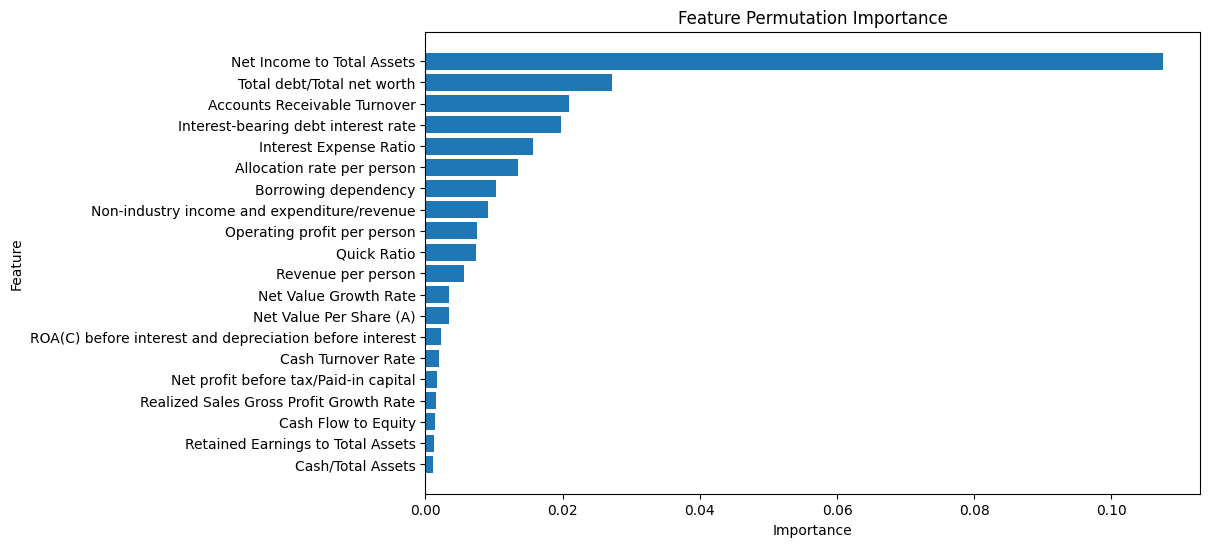

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Original feat removed so far:  ['Net Income to Total Assets']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Net Income to Total Assets', 'Total debt/Total net worth', 'Accounts Receivable Turnover', 'Interest-bearing debt interest rate', 'Interest Expense Ratio']

--- NEW ITERATION

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1218  102  10      25.00   77.27        92.27     91.79     37.78   
1   14  1301   19  30      42.42   31.82        98.56     96.41     36.36   
2   12  1303   17  32      41.38   27.27        98.71     96.41     32.88   
3   10  1311    9  34      52.63   22.73        99.32     96.85     31.75   
4    5  1316    4  39      55.56   11.36        99.70     96.85     18.87   
5    5  1316    4  39      55.56   11.36        99.70     96.85     18.87   
6    5  1316    4  39      55.56   11.36        99.70     96.85     18.87   
7    0  1317    3  44       0.00    0.00        99.77     96.55      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.77                 0   
1               65.19                 1   
2               62.99                 2   
3               61.02                 3   
4               55.53                 4   
5               55.53                 5   
6               55.53                 6   
7               49.89                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:35:22.554482

--- NEW ITERATION ---
Removing feature:  Net Income to Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   34  1218  102  10      25.00   77.27        92.27     91.79     37.78   
1   32  1223   97  12      24.81   72.73        92.65     92.01     36.99   
2   32  1220  100  12      24.24   72.73        92.42     91.79     36.36   
3   29  1241   79  15      26.85   65.91        94.02     93.11     38.16   
4   30  1233   87  14      25.64   68.18        93.41     92.60     37.27   
5   30  1234   86  14      25.86   68.18        93.48     92.67     37.50   
6   33  1228   92  11      26.40   75.00        93.03     92.45     39.05   
7   32  1230   90  12      26.23   72.73        93.18     92.52     38.55   
8   33  1225   95  11      25.78   75.00        92.80     92.23     38.37   
9   33  1221   99  11      25.00   75.00        92.50     91.94     37.50   
10  32  1249   71  12      31.07   72.73        94.62     93.91     43.54   
11  32  1251   69  12      31.68   72.73        94.77     94.06     44.14   
12  31  1255   65  13      32.29   70.45        95.08     94.28     44.29   
13  30  1257   63  14      32.26   68.18        95.23     94.35     43.80   
14  32  1254   66  12      32.65   72.73        95.00     94.28     45.07   
15  30  1254   66  14      31.25   68.18        95.00     94.13     42.86   
16  30  1258   62  14      32.61   68.18        95.30     94.43     44.12   
17  30  1260   60  14      33.33   68.18        95.45     94.57     44.78   
18  30  1260   60  14      33.33   68.18        95.45     94.57     44.78   
19  29  1262   58  15      33.33   65.91        95.61     94.65     44.27   
20  28  1263   57  16      32.94   63.64        95.68     94.65     43.41   

    balanced_accuracy  num_feat_missing  \
0               84.77                 0   
1               82.69                 1   
2               82.58                 2   
3               79.96                 3   
4               80.80                 4   
5               80.83                 5   
6               84.02                 6   
7               82.95                 7   
8               83.90                 8   
9               83.75                 9   
10              83.67                10   
11              83.75                11   
12              82.77                12   
13              81.70                13   
14              83.86                14   
15              81.59                15   
16              81.74                16   
17              81.82                17   
18              81.82                18   
19              80.76                19   
20              79.66                20   

                                              imputed  
0                                                      
1              ['Net Income to Total Assets'] imputed  
2   ['Net Income to Total Assets', 'Total debt/Tot...  
3   ['Net Income to Total Assets', 'Total debt/Tot...  
4   ['Net Income to Total Assets', 'Total debt/Tot...  
5   ['Net Income to Total Assets', 'Total debt/Tot...  
6   ['Net Income to Total Assets', 'Total debt/Tot...  
7   ['Net Income to Total Assets', 'Total debt/Tot...  
8   ['Net Income to Total Assets', 'Total debt/Tot...  
9   ['Net Income to Total Assets', 'Total debt/Tot...  
10  ['Net Income to Total Assets', 'Total debt/Tot...  
11  ['Net Income to Total Assets', 'Total debt/Tot...  
12  ['Net Income to Total Assets', 'Total debt/Tot...  
13  ['Net Income to Total Assets', 'Total debt/Tot...  
14  ['Net Income to Total Assets', 'Total debt/Tot...  
15  ['Net Income to Total Assets', 'Total debt/Tot...  
16  ['Net Income to Total Assets', 'Total debt/Tot...  
17  ['Net Income to Total Assets', 'Total debt/Tot...  
18  ['Net Income to Total Assets', 'Total debt/Tot...  
19  ['Net Income to Total Assets', 'Total debt/Tot...  
20  ['Net Income to Total Assets', 'Total debt/Tot...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[0.75]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:45:23.370961

Nested Cross-validation Results:
Individual scores: [0.82700308 0.78212187 0.80242048]
Average nested CV score: 0.804 (+/- 0.037)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.804
2025-01-16 14:45:28.481652

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:23:36.833708

Nested Cross-validation Results:
Individual scores: [0.6409428  0.64456309 0.64037252]
Average nested CV score: 0.642 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.667

2025-01-13 02:45:25.416343

Execution time: 21.81 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 17:19:20.690361

Nested Cross-validation Results:
Individual scores: [0.80976984 0.75824843 0.79758819]
Average nested CV score: 0.789 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.75, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.804

2025-01-15 17:44:39.344193

Execution time: 25.31 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
52                         Allocation rate per person    0.005587  0.002371
48                    Fixed Assets Turnover Frequency    0.004053  0.001453
13                Interest-bearing debt interest rate    0.003996  0.003035
45                       Accounts Receivable Turnover    0.003750  0.002885
50                                 Revenue per person    0.003106  0.001460
..                                                ...         ...       ...
0   ROA(C) before interest and depreciation before...   -0.003201  0.000093
2   ROA(B) before interest and depreciation after tax   -0.003675  0.000152
18            Persistent EPS in the Last Four Seasons   -0.004130  0.000430
39                               Borrowing dependency   -0.004395  0.000326
9                Continuous interest rate (after tax)   -0.006611  0.000450

[81 rows x 3 columns]

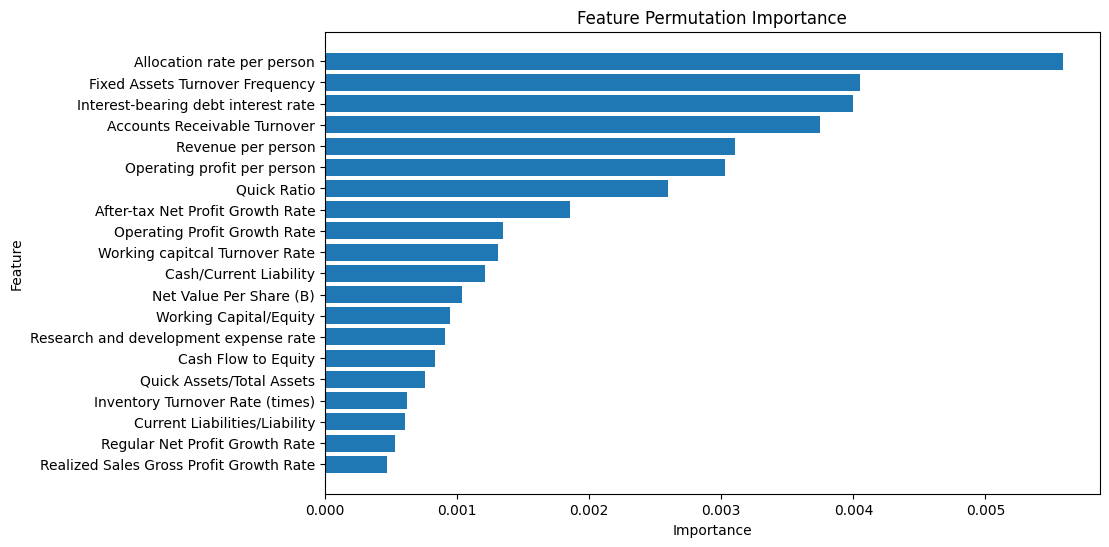

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Allocation rate per person', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Allocation rate per person', 'Fixed Assets Turnover Frequency', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Allocation rate per person', 'Fixed Assets Turnover Frequency', 'Interest-bearing debt interest rate', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Allocation rate per person', 'Fixed Assets Turnover Frequency', 'Interest-bearing debt interest rate', 'Accounts Receivable Turnover', 'Revenue per per

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
1   26  1268  52  18      33.33   59.09        96.06     94.87     42.62   
2   26  1266  54  18      32.50   59.09        95.91     94.72     41.94   
3   26  1274  46  18      36.11   59.09        96.52     95.31     44.83   
4   25  1286  34  19      42.37   56.82        97.42     96.11     48.54   
5   26  1283  37  18      41.27   59.09        97.20     95.97     48.60   
6   26  1280  40  18      39.39   59.09        96.97     95.75     47.27   
7   15  1299  21  29      41.67   34.09        98.41     96.33     37.50   
8   18  1296  24  26      42.86   40.91        98.18     96.33     41.86   
9   18  1292  28  26      39.13   40.91        97.88     96.04     40.00   
10  16  1296  24  28      40.00   36.36        98.18     96.19     38.10   
11  18  1294  26  26      40.91   40.91        98.03     96.19     40.91   
12  15  1297  23  29      39.47   34.09        98.26     96.19     36.59   
13  15  1296  24  29      38.46   34.09        98.18     96.11     36.14   
14  17  1296  24  27      41.46   38.64        98.18     96.26     40.00   
15  17  1297  23  27      42.50   38.64        98.26     96.33     40.48   
16  16  1298  22  28      42.11   36.36        98.33     96.33     39.02   
17  16  1300  20  28      44.44   36.36        98.48     96.48     40.00   
18  16  1300  20  28      44.44   36.36        98.48     96.48     40.00   
19  17  1301  19  27      47.22   38.64        98.56     96.63     42.50   
20  19  1299  21  25      47.50   43.18        98.41     96.63     45.24   

    balanced_accuracy  num_feat_missing  \
0               78.45                 0   
1               77.58                 1   
2               77.50                 2   
3               77.80                 3   
4               77.12                 4   
5               78.14                 5   
6               78.03                 6   
7               66.25                 7   
8               69.55                 8   
9               69.39                 9   
10              67.27                10   
11              69.47                11   
12              66.17                12   
13              66.14                13   
14              68.41                14   
15              68.45                15   
16              67.35                16   
17              67.42                17   
18              67.42                18   
19              68.60                19   
20              70.80                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Fixed Assets T...  
3   ['Allocation rate per person', 'Fixed Assets T...  
4   ['Allocation rate per person', 'Fixed Assets T...  
5   ['Allocation rate per person', 'Fixed Assets T...  
6   ['Allocation rate per person', 'Fixed Assets T...  
7   ['Allocation rate per person', 'Fixed Assets T...  
8   ['Allocation rate per person', 'Fixed Assets T...  
9   ['Allocation rate per person', 'Fixed Assets T...  
10  ['Allocation rate per person', 'Fixed Assets T...  
11  ['Allocation rate per person', 'Fixed Assets T...  
12  ['Allocation rate per person', 'Fixed Assets T...  
13  ['Allocation rate per person', 'Fixed Assets T...  
14  ['Allocation rate per person', 'Fixed Assets T...  
15  ['Allocation rate per person', 'Fixed Assets T...  
16  ['Allocation rate per person', 'Fixed Assets T...  
17  ['Allocation rate per person', 'Fixed Assets T...  
18  ['Allocation rate per person', 'Fixed Assets T...  
19  ['Allocation rate per person', 'Fixed Assets T...  
20  ['Allocation rate per person', 'Fixed Assets T...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:45:32.666152

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 

In [ ]:
xgb2_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
1   29  1259  61  15      32.22   65.91        95.38     94.43     43.28   
2   31  1250  70  13      30.69   70.45        94.70     93.91     42.76   
3   30  1243  77  14      28.04   68.18        94.17     93.33     39.74   
4   27  1262  58  17      31.76   61.36        95.61     94.50     41.86   
5   30  1254  66  14      31.25   68.18        95.00     94.13     42.86   
6   30  1251  69  14      30.30   68.18        94.77     93.91     41.96   
7   22  1276  44  22      33.33   50.00        96.67     95.16     40.00   
8   22  1279  41  22      34.92   50.00        96.89     95.38     41.12   
9   19  1281  39  25      32.76   43.18        97.05     95.31     37.25   
10  21  1281  39  23      35.00   47.73        97.05     95.45     40.38   
11  22  1278  42  22      34.38   50.00        96.82     95.31     40.74   
12  22  1278  42  22      34.38   50.00        96.82     95.31     40.74   
13  21  1280  40  23      34.43   47.73        96.97     95.38     40.00   
14  23  1280  40  21      36.51   52.27        96.97     95.53     42.99   
15  22  1281  39  22      36.07   50.00        97.05     95.53     41.90   
16  20  1289  31  24      39.22   45.45        97.65     95.97     42.11   
17  19  1293  27  25      41.30   43.18        97.95     96.19     42.22   
18  19  1291  29  25      39.58   43.18        97.80     96.04     41.30   
19  20  1290  30  24      40.00   45.45        97.73     96.04     42.55   
20  19  1295  25  25      43.18   43.18        98.11     96.33     43.18   

    balanced_accuracy  num_feat_missing  \
0               78.45                 0   
1               80.64                 1   
2               82.58                 2   
3               81.17                 3   
4               78.48                 4   
5               81.59                 5   
6               81.48                 6   
7               73.33                 7   
8               73.45                 8   
9               70.11                 9   
10              72.39                10   
11              73.41                11   
12              73.41                12   
13              72.35                13   
14              74.62                14   
15              73.52                15   
16              71.55                16   
17              70.57                17   
18              70.49                18   
19              71.59                19   
20              70.64                20   

                                              imputed  
0                                                      
1              ['Allocation rate per person'] imputed  
2   ['Allocation rate per person', 'Fixed Assets T...  
3   ['Allocation rate per person', 'Fixed Assets T...  
4   ['Allocation rate per person', 'Fixed Assets T...  
5   ['Allocation rate per person', 'Fixed Assets T...  
6   ['Allocation rate per person', 'Fixed Assets T...  
7   ['Allocation rate per person', 'Fixed Assets T...  
8   ['Allocation rate per person', 'Fixed Assets T...  
9   ['Allocation rate per person', 'Fixed Assets T...  
10  ['Allocation rate per person', 'Fixed Assets T...  
11  ['Allocation rate per person', 'Fixed Assets T...  
12  ['Allocation rate per person', 'Fixed Assets T...  
13  ['Allocation rate per person', 'Fixed Assets T...  
14  ['Allocation rate per person', 'Fixed Assets T...  
15  ['Allocation rate per person', 'Fixed Assets T...  
16  ['Allocation rate per person', 'Fixed Assets T...  
17  ['Allocation rate per person', 'Fixed Assets T...  
18  ['Allocation rate per person', 'Fixed Assets T...  
19  ['Allocation rate per person', 'Fixed Assets T...  
20  ['Allocation rate per person', 'Fixed Assets T...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [200],
      'max_depth': [5],
      'max_features':['sqrt'],
      'min_samples_split': [2],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 14:55:28.398170

Nested Cross-validation Results:
Individual scores: [0.87306433 0.87857563 0.84959193]
Average nested CV score: 0.867 (+/- 0.025)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.867
2025-01-16 14:55:34.429476

Execution time: 0.10 minutes




```
Starting hyperparameter tuning at: 2025-01-15 17:44:39.351866

Nested Cross-validation Results:
Individual scores: [0.86226888 0.84627743 0.84140161]
Average nested CV score: 0.850 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.867

2025-01-15 18:04:51.064164

Execution time: 20.20 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
78            Equity to Long-term Liability    0.004886  0.000811
35               Total debt/Total net worth    0.002708  0.000097
47          Inventory Turnover Rate (times)    0.002405  0.001162
44                     Total Asset Turnover    0.002254  0.002032
37                         Net worth/Assets    0.002252  0.003831
..                                      ...         ...       ...
1    ROA(A) before interest and % after tax   -0.001648  0.001411
42    Net profit before tax/Paid-in capital   -0.002179  0.001599
17                  Net Value Per Share (C)   -0.002520  0.001378
18  Persistent EPS in the Last Four Seasons   -0.002633  0.000250
15                  Net Value Per Share (B)   -0.003448  0.001005

[87 rows x 3 columns]

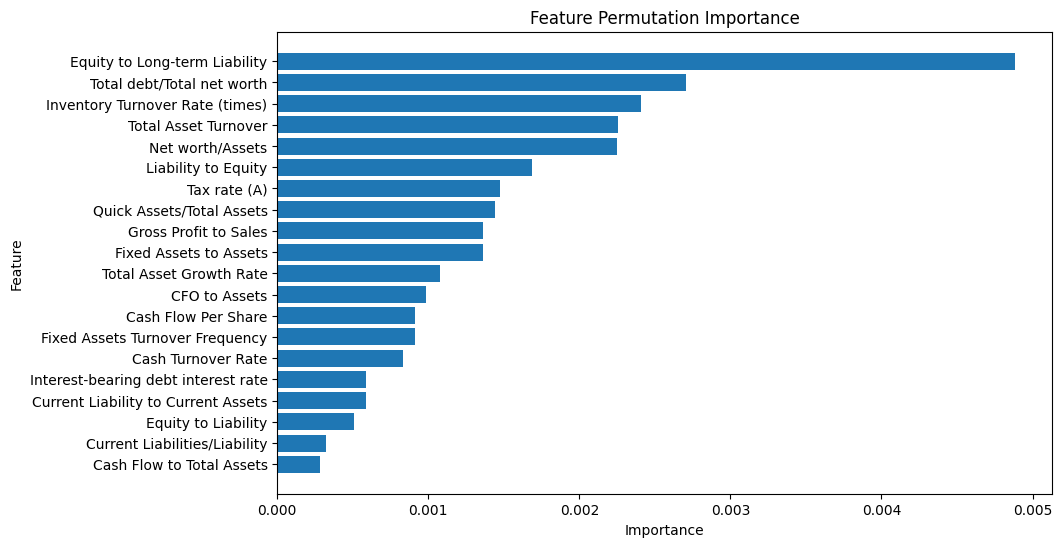

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Long-term Liability
Original feat removed so far:  ['Equity to Long-term Liability']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Equity to Long-term Liability', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Equity to Long-term Liability', 'Total debt/Total net worth', 'Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Long-term Liability', 'Total debt/Total net worth', 'Inventory Turnover Rate (times)', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Original feat removed so far:  ['Equity to Long-term Liability', 'Total debt/Total net worth', 'Inventory Turnover Rate (times)', 'Total Asset Turnover', 'Net worth/Assets']

--- NEW ITERATION ---
Removing feature:  Lia

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
1   38  1162  158   6      19.39   86.36        88.03     87.98     31.67   
2   38  1162  158   6      19.39   86.36        88.03     87.98     31.67   
3   38  1162  158   6      19.39   86.36        88.03     87.98     31.67   
4   38  1168  152   6      20.00   86.36        88.48     88.42     32.48   
5   36  1174  146   8      19.78   81.82        88.94     88.71     31.86   
6   36  1178  142   8      20.22   81.82        89.24     89.00     32.43   
7   33  1203  117  11      22.00   75.00        91.14     90.62     34.02   
8   33  1207  113  11      22.60   75.00        91.44     90.91     34.74   
9   33  1209  111  11      22.92   75.00        91.59     91.06     35.11   
10  33  1210  110  11      23.08   75.00        91.67     91.13     35.29   
11  33  1207  113  11      22.60   75.00        91.44     90.91     34.74   
12  32  1211  109  12      22.70   72.73        91.74     91.13     34.59   
13  32  1213  107  12      23.02   72.73        91.89     91.28     34.97   
14  31  1223   97  13      24.22   70.45        92.65     91.94     36.05   
15  31  1217  103  13      23.13   70.45        92.20     91.50     34.83   
16  31  1216  104  13      22.96   70.45        92.12     91.42     34.64   
17  31  1217  103  13      23.13   70.45        92.20     91.50     34.83   
18  30  1222   98  14      23.44   68.18        92.58     91.79     34.88   
19  30  1221   99  14      23.26   68.18        92.50     91.72     34.68   
20  31  1221   99  13      23.85   70.45        92.50     91.79     35.63   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               87.20                 1   
2               87.20                 2   
3               87.20                 3   
4               87.42                 4   
5               85.38                 5   
6               85.53                 6   
7               83.07                 7   
8               83.22                 8   
9               83.30                 9   
10              83.33                10   
11              83.22                11   
12              82.23                12   
13              82.31                13   
14              81.55                14   
15              81.33                15   
16              81.29                16   
17              81.33                17   
18              80.38                18   
19              80.34                19   
20              81.48                20   

                                              imputed  
0                                                      
1           ['Equity to Long-term Liability'] imputed  
2   ['Equity to Long-term Liability', 'Total debt/...  
3   ['Equity to Long-term Liability', 'Total debt/...  
4   ['Equity to Long-term Liability', 'Total debt/...  
5   ['Equity to Long-term Liability', 'Total debt/...  
6   ['Equity to Long-term Liability', 'Total debt/...  
7   ['Equity to Long-term Liability', 'Total debt/...  
8   ['Equity to Long-term Liability', 'Total debt/...  
9   ['Equity to Long-term Liability', 'Total debt/...  
10  ['Equity to Long-term Liability', 'Total debt/...  
11  ['Equity to Long-term Liability', 'Total debt/...  
12  ['Equity to Long-term Liability', 'Total debt/...  
13  ['Equity to Long-term Liability', 'Total debt/...  
14  ['Equity to Long-term Liability', 'Total debt/...  
15  ['Equity to Long-term Liability', 'Total debt/...  
16  ['Equity to Long-term Liability', 'Total debt/...  
17  ['Equity to Long-term Liability', 'Total debt/...  
18  ['Equity to Long-term Liability', 'Total debt/...  
19  ['Equity to Long-term Liability', 'Total debt/...  
20  ['Equity to Long-term Liability', 'Total debt/...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 14:55:40.412369

--- NEW ITERATION ---
Removing feature:  Equity to Long-term Liability
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
1   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
2   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
3   39  1162  158   5      19.80   88.64        88.03     88.05     32.37   
4   39  1163  157   5      19.90   88.64        88.11     88.12     32.50   
5   39  1161  159   5      19.70   88.64        87.95     87.98     32.23   
6   38  1163  157   6      19.49   86.36        88.11     88.05     31.80   
7   38  1176  144   6      20.88   86.36        89.09     89.00     33.63   
8   38  1183  137   6      21.71   86.36        89.62     89.52     34.70   
9   38  1183  137   6      21.71   86.36        89.62     89.52     34.70   
10  38  1184  136   6      21.84   86.36        89.70     89.59     34.86   
11  38  1174  146   6      20.65   86.36        88.94     88.86     33.33   
12  38  1171  149   6      20.32   86.36        88.71     88.64     32.90   
13  38  1172  148   6      20.43   86.36        88.79     88.71     33.04   
14  38  1165  155   6      19.69   86.36        88.26     88.20     32.07   
15  37  1162  158   7      18.97   84.09        88.03     87.90     30.96   
16  38  1160  160   6      19.19   86.36        87.88     87.83     31.40   
17  37  1162  158   7      18.97   84.09        88.03     87.90     30.96   
18  37  1167  153   7      19.47   84.09        88.41     88.27     31.62   
19  37  1168  152   7      19.58   84.09        88.48     88.34     31.76   
20  37  1167  153   7      19.47   84.09        88.41     88.27     31.62   

    balanced_accuracy  num_feat_missing  \
0               88.30                 0   
1               88.30                 1   
2               88.30                 2   
3               88.33                 3   
4               88.37                 4   
5               88.30                 5   
6               87.23                 6   
7               87.73                 7   
8               87.99                 8   
9               87.99                 9   
10              88.03                10   
11              87.65                11   
12              87.54                12   
13              87.58                13   
14              87.31                14   
15              86.06                15   
16              87.12                16   
17              86.06                17   
18              86.25                18   
19              86.29                19   
20              86.25                20   

                                              imputed  
0                                                      
1           ['Equity to Long-term Liability'] imputed  
2   ['Equity to Long-term Liability', 'Total debt/...  
3   ['Equity to Long-term Liability', 'Total debt/...  
4   ['Equity to Long-term Liability', 'Total debt/...  
5   ['Equity to Long-term Liability', 'Total debt/...  
6   ['Equity to Long-term Liability', 'Total debt/...  
7   ['Equity to Long-term Liability', 'Total debt/...  
8   ['Equity to Long-term Liability', 'Total debt/...  
9   ['Equity to Long-term Liability', 'Total debt/...  
10  ['Equity to Long-term Liability', 'Total debt/...  
11  ['Equity to Long-term Liability', 'Total debt/...  
12  ['Equity to Long-term Liability', 'Total debt/...  
13  ['Equity to Long-term Liability', 'Total debt/...  
14  ['Equity to Long-term Liability', 'Total debt/...  
15  ['Equity to Long-term Liability', 'Total debt/...  
16  ['Equity to Long-term Liability', 'Total debt/...  
17  ['Equity to Long-term Liability', 'Total debt/...  
18  ['Equity to Long-term Liability', 'Total debt/...  
19  ['Equity to Long-term Liability', 'Total debt/...  
20  ['Equity to Long-term Liability', 'Total debt/...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [1.0],
    'kernel': ['rbf'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 15:05:36.860528

Nested Cross-validation Results:
Individual scores: [0.86567797 0.84134992 0.8354323 ]
Average nested CV score: 0.847 (+/- 0.026)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.847
2025-01-16 15:05:44.385242

Execution time: 0.13 minutes




```
Starting hyperparameter tuning at: 2025-01-15 18:04:51.073441

Nested Cross-validation Results:
Individual scores: [0.81341005 0.83092672 0.8408331 ]
Average nested CV score: 0.828 (+/- 0.023)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.847

2025-01-15 18:10:41.098810

Execution time: 5.83 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
56                    Cash/Total Assets    0.021495  0.002898
37                     Net worth/Assets    0.009355  0.005464
36                         Debt ratio %    0.009355  0.005464
28              Total Asset Growth Rate    0.008769  0.003965
44                 Total Asset Turnover    0.008750  0.004251
..                                  ...         ...       ...
3                Operating Gross Margin   -0.000322  0.000128
83  Current Liability to Current Assets   -0.000322  0.001019
79            Cash Flow to Total Assets   -0.000360  0.000381
78        Equity to Long-term Liability   -0.000360  0.000235
39                 Borrowing dependency   -0.000398  0.000071

[75 rows x 3 columns]

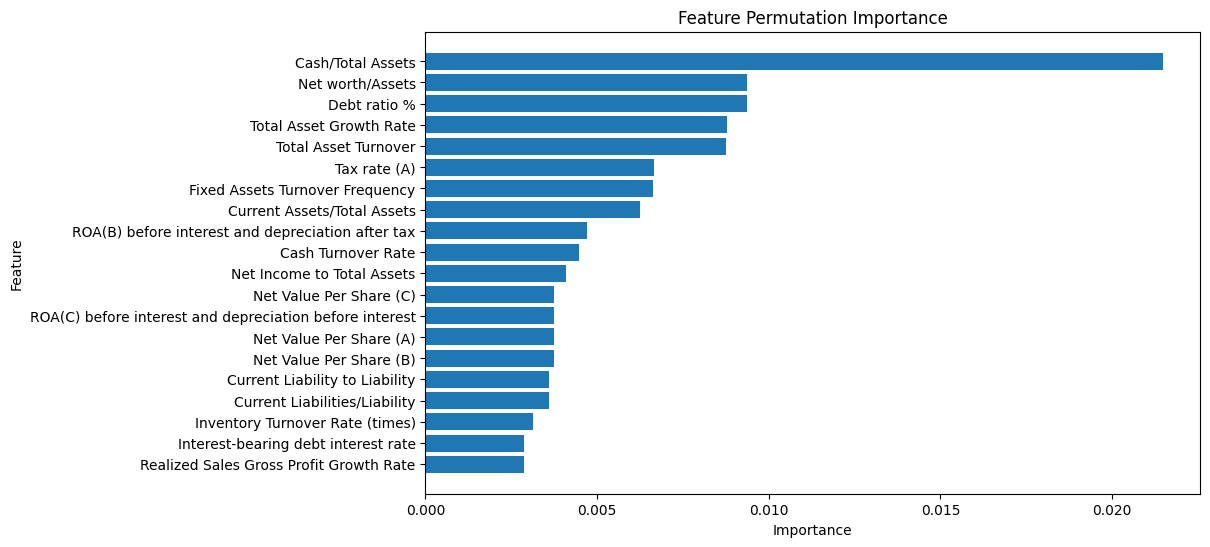

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Debt ratio %
Original feat removed so far:  ['Cash/Total Assets', 'Debt ratio %']

--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Original feat removed so far:  ['Cash/Total Assets', 'Debt ratio %', 'Net worth/Assets']

--- NEW ITERATION ---
Removing feature:  Total Asset Growth Rate
Original feat removed so far:  ['Cash/Total Assets', 'Debt ratio %', 'Net worth/Assets', 'Total Asset Growth Rate']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Cash/Total Assets', 'Debt ratio %', 'Net worth/Assets', 'Total Asset Growth Rate', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Tax rate (A)
Original feat removed so far:  ['Cash/Total Assets', 'Debt ratio %', 'Net worth/Assets', 'Total Asset Growth Rate', 'Total Asset Turnover', 'Tax rate (A)']

--- NEW ITERATION 

In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1135  185   5      17.41   88.64        85.98     86.07     29.10   
1   39  1139  181   5      17.73   88.64        86.29     86.36     29.55   
2   37  1168  152   7      19.58   84.09        88.48     88.34     31.76   
3   32  1190  130  12      19.75   72.73        90.15     89.59     31.07   
4   32  1203  117  12      21.48   72.73        91.14     90.54     33.16   
5   32  1210  110  12      22.54   72.73        91.67     91.06     34.41   
6   31  1220  100  13      23.66   70.45        92.42     91.72     35.43   
7   27  1252   68  17      28.42   61.36        94.85     93.77     38.85   
8   27  1232   88  17      23.48   61.36        93.33     92.30     33.96   
9   24  1266   54  20      30.77   54.55        95.91     94.57     39.34   
10  25  1264   56  19      30.86   56.82        95.76     94.50     40.00   
11  22  1279   41  22      34.92   50.00        96.89     95.38     41.12   
12  22  1282   38  22      36.67   50.00        97.12     95.60     42.31   
13  16  1303   17  28      48.48   36.36        98.71     96.70     41.56   
14  16  1304   16  28      50.00   36.36        98.79     96.77     42.11   
15  14  1304   16  30      46.67   31.82        98.79     96.63     37.84   
16  14  1305   15  30      48.28   31.82        98.86     96.70     38.36   
17  14  1303   17  30      45.16   31.82        98.71     96.55     37.33   
18  16  1302   18  28      47.06   36.36        98.64     96.63     41.03   
19  16  1300   20  28      44.44   36.36        98.48     96.48     40.00   
20  16  1300   20  28      44.44   36.36        98.48     96.48     40.00   

    balanced_accuracy  num_feat_missing  \
0               87.31                 0   
1               87.46                 1   
2               86.29                 2   
3               81.44                 3   
4               81.93                 4   
5               82.20                 5   
6               81.44                 6   
7               78.11                 7   
8               77.35                 8   
9               75.23                 9   
10              76.29                10   
11              73.45                11   
12              73.56                12   
13              67.54                13   
14              67.58                14   
15              65.30                15   
16              65.34                16   
17              65.27                17   
18              67.50                18   
19              67.42                19   
20              67.42                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2       ['Cash/Total Assets', 'Debt ratio %'] imputed  
3   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
4   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
5   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
6   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
7   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
8   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
9   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
10  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
11  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
12  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
13  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
14  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
15  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
16  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
17  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
18  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
19  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
20  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 15:07:31.713937

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-ta

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1135  185   5      17.41   88.64        85.98     86.07     29.10   
1   39  1136  184   5      17.49   88.64        86.06     86.14     29.21   
2   39  1135  185   5      17.41   88.64        85.98     86.07     29.10   
3   39  1145  175   5      18.22   88.64        86.74     86.80     30.23   
4   39  1141  179   5      17.89   88.64        86.44     86.51     29.77   
5   39  1144  176   5      18.14   88.64        86.67     86.73     30.12   
6   39  1153  167   5      18.93   88.64        87.35     87.39     31.20   
7   39  1162  158   5      19.80   88.64        88.03     88.05     32.37   
8   38  1160  160   6      19.19   86.36        87.88     87.83     31.40   
9   38  1159  161   6      19.10   86.36        87.80     87.76     31.28   
10  38  1159  161   6      19.10   86.36        87.80     87.76     31.28   
11  38  1166  154   6      19.79   86.36        88.33     88.27     32.20   
12  38  1168  152   6      20.00   86.36        88.48     88.42     32.48   
13  37  1176  144   7      20.44   84.09        89.09     88.93     32.89   
14  37  1178  142   7      20.67   84.09        89.24     89.08     33.18   
15  37  1184  136   7      21.39   84.09        89.70     89.52     34.10   
16  38  1179  141   6      21.23   86.36        89.32     89.22     34.08   
17  37  1177  143   7      20.56   84.09        89.17     89.00     33.04   
18  37  1171  149   7      19.89   84.09        88.71     88.56     32.17   
19  37  1173  147   7      20.11   84.09        88.86     88.71     32.46   
20  37  1176  144   7      20.44   84.09        89.09     88.93     32.89   

    balanced_accuracy  num_feat_missing  \
0               87.31                 0   
1               87.35                 1   
2               87.31                 2   
3               87.69                 3   
4               87.54                 4   
5               87.65                 5   
6               87.99                 6   
7               88.33                 7   
8               87.12                 8   
9               87.08                 9   
10              87.08                10   
11              87.35                11   
12              87.42                12   
13              86.59                13   
14              86.67                14   
15              86.89                15   
16              87.84                16   
17              86.63                17   
18              86.40                18   
19              86.48                19   
20              86.59                20   

                                              imputed  
0                                                      
1                       ['Cash/Total Assets'] imputed  
2       ['Cash/Total Assets', 'Debt ratio %'] imputed  
3   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
4   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
5   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
6   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
7   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
8   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
9   ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
10  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
11  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
12  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
13  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
14  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
15  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
16  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
17  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
18  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
19  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...  
20  ['Cash/Total Assets', 'Debt ratio %', 'Net wor...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

62

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [2.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 15:16:31.642159

Nested Cross-validation Results:
Individual scores: [0.8074923  0.82638127 0.83321128]
Average nested CV score: 0.822 (+/- 0.022)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822
2025-01-16 15:17:11.578892

Execution time: 0.67 minutes




```
Starting hyperparameter tuning at: 2025-01-15 18:10:41.114085

Nested Cross-validation Results:
Individual scores: [0.8074923  0.82638127 0.83179002]
Average nested CV score: 0.822 (+/- 0.021)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.822

2025-01-15 18:13:20.747230

Execution time: 2.66 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
10                      Equity to Liability    0.072290  0.010652
22                        Cash/Total Assets    0.057801  0.008324
1                      Borrowing dependency    0.038426  0.006290
7       Operating Profit Per Share (Yuan ¥)    0.030548  0.010271
32                     Total Asset Turnover    0.019413  0.003423
23                     Total expense/Assets    0.017387  0.003151
31                   Cash Flow to Liability    0.015417  0.003916
2         Retained Earnings to Total Assets    0.014242  0.005721
33                Quick Assets/Total Assets    0.013998  0.005050
27                      Cash Flow to Equity    0.008959  0.001256
50          Inventory Turnover Rate (times)    0.006819  0.001816
44                       Cash Turnover Rate    0.006667  0.002952
48           Current Liability to Liability    0.006573  0.000690
12                    Liability-Assets Flag    0.006174  0.000071
47      Interest-bearing debt interest rate    0.006023  0.003928
5                   Net Value Per Share (A)    0.005927  0.005631
36                  Total Asset Growth Rate    0.004546  0.001164
49                Quick Asset Turnover Rate    0.003352  0.001433
45               Total debt/Total net worth    0.003163  0.000076
39  Realized Sales Gross Profit Growth Rate    0.003030  0.000300
17                   Operating Gross Margin    0.002689  0.001990
55             Accounts Receivable Turnover    0.002140  0.001403
4       Current Liability to Current Assets    0.001894  0.001708
13                             Tax rate (A)    0.001761  0.001458
51                Total assets to GNP price    0.001591  0.001304
0        Net Income to Stockholder's Equity    0.001307  0.001420
59                   Operating Expense Rate    0.000473  0.002111
18                           Cash flow rate    0.000417  0.001496
26                   Cash/Current Liability    0.000208  0.000110
14                   Interest Expense Ratio    0.000095  0.000060
34                   Fixed Assets to Assets    0.000019  0.000038
43                              Quick Ratio    0.000019  0.000038
57              Inventory/Current Liability    0.000019  0.000071
56                  Average Collection Days    0.000019  0.000110
24         After-tax Net Profit Growth Rate    0.000019  0.000126
53    Long-term Liability to Current Assets   -0.000152  0.000076
30       Degree of Financial Leverage (DFL)   -0.000322  0.000128
11              Operating profit per person   -0.000398  0.001089
9             Equity to Long-term Liability   -0.001099  0.001033
46    Research and development expense rate   -0.001136  0.001355
54              Current Asset Turnover Rate   -0.002576  0.002165
38          Fixed Assets Turnover Frequency   -0.004830  0.001919

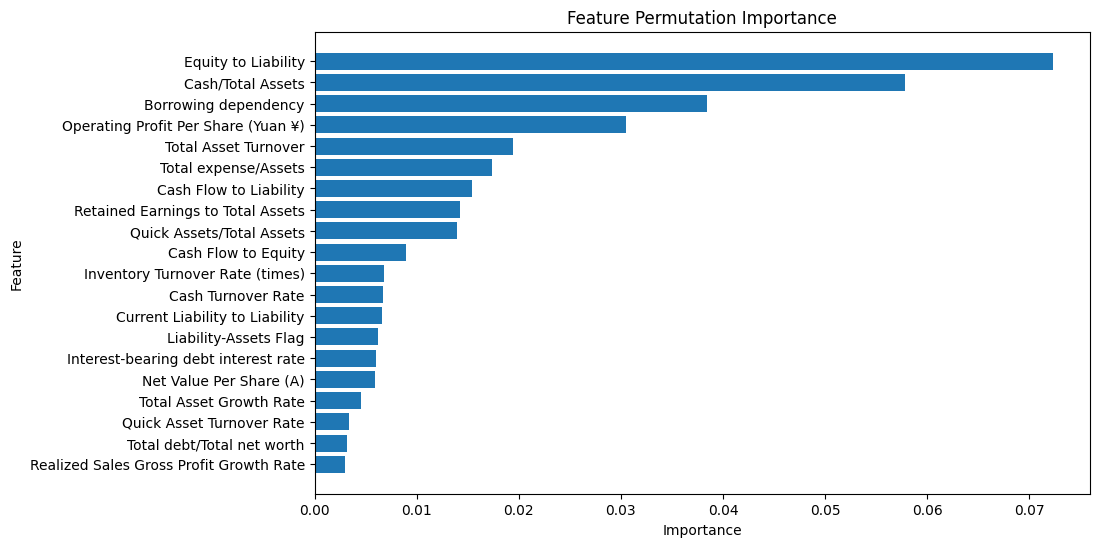

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Operating Profit Per Share (Yuan ¥)
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency', 'Operating Profit Per Share (Yuan ¥)']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'Borrowing dependency', 'Operating Profit Per Share (Yuan ¥)', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Cash/Total Assets', 'B

In [ ]:
lr2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1128  192   8      15.79   81.82        85.45     85.34     26.47   
1   34  1143  177  10      16.11   77.27        86.59     86.29     26.67   
2   33  1146  174  11      15.94   75.00        86.82     86.44     26.29   
3   15  1278   42  29      26.32   34.09        96.82     94.79     29.70   
4    9  1290   30  35      23.08   20.45        97.73     95.23     21.69   
5    8  1291   29  36      21.62   18.18        97.80     95.23     19.75   
6    2  1303   17  42      10.53    4.55        98.71     95.67      6.35   
7    2  1308   12  42      14.29    4.55        99.09     96.04      6.90   
8    2  1312    8  42      20.00    4.55        99.39     96.33      7.41   
9    2  1313    7  42      22.22    4.55        99.47     96.41      7.55   
10   2  1317    3  42      40.00    4.55        99.77     96.70      8.16   
11   2  1317    3  42      40.00    4.55        99.77     96.70      8.16   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               83.64                 0   
1               81.93                 1   
2               80.91                 2   
3               65.45                 3   
4               59.09                 4   
5               57.99                 5   
6               51.63                 6   
7               51.82                 7   
8               51.97                 8   
9               52.01                 9   
10              52.16                10   
11              52.16                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash/Total Assets'] i...  
3   ['Equity to Liability', 'Cash/Total Assets', '...  
4   ['Equity to Liability', 'Cash/Total Assets', '...  
5   ['Equity to Liability', 'Cash/Total Assets', '...  
6   ['Equity to Liability', 'Cash/Total Assets', '...  
7   ['Equity to Liability', 'Cash/Total Assets', '...  
8   ['Equity to Liability', 'Cash/Total Assets', '...  
9   ['Equity to Liability', 'Cash/Total Assets', '...  
10  ['Equity to Liability', 'Cash/Total Assets', '...  
11  ['Equity to Liability', 'Cash/Total Assets', '...  
12  ['Equity to Liability', 'Cash/Total Assets', '...  
13  ['Equity to Liability', 'Cash/Total Assets', '...  
14  ['Equity to Liability', 'Cash/Total Assets', '...  
15  ['Equity to Liability', 'Cash/Total Assets', '...  
16  ['Equity to Liability', 'Cash/Total Assets', '...  
17  ['Equity to Liability', 'Cash/Total Assets', '...  
18  ['Equity to Liability', 'Cash/Total Assets', '...  
19  ['Equity to Liability', 'Cash/Total Assets', '...  
20  ['Equity to Liability', 'Cash/Total Assets', '...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 15:17:25.151601

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Continuous interest rate (after tax)', 'Equity to Long-term Liability', 'Equity to Liability', 'Operating profit per person', 'Tax rate (A)', 'Interest Expense Ratio', 'Total income/Total expense', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Operating Gross Margin', 'Cash flow rate', 'Inventory and accounts receivable/Net value', 'Total Asset Return Growth Rate Ratio', 'Cash Flow Per Share', 'Cash/Total Assets', 'Total expense/Assets', 'After-tax Net Profit Growth Rate', 'No-credit Interval', 'Cash/Current Liability', 'Cash Flow to Equity', 'Inventory/Working Capital', 'Contingent liab

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1128  192   8      15.79   81.82        85.45     85.34     26.47   
1   35  1141  179   9      16.36   79.55        86.44     86.22     27.13   
2   35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
3   34  1180  140  10      19.54   77.27        89.39     89.00     31.19   
4   33  1184  136  11      19.53   75.00        89.70     89.22     30.99   
5   35  1189  131   9      21.08   79.55        90.08     89.74     33.33   
6   34  1188  132  10      20.48   77.27        90.00     89.59     32.38   
7   34  1183  137  10      19.88   77.27        89.62     89.22     31.63   
8   33  1193  127  11      20.62   75.00        90.38     89.88     32.35   
9   34  1196  124  10      21.52   77.27        90.61     90.18     33.66   
10  34  1204  116  10      22.67   77.27        91.21     90.76     35.05   
11  32  1209  111  12      22.38   72.73        91.59     90.98     34.22   
12  33  1197  123  11      21.15   75.00        90.68     90.18     33.00   
13  32  1198  122  12      20.78   72.73        90.76     90.18     32.32   
14  31  1199  121  13      20.39   70.45        90.83     90.18     31.63   
15  32  1202  118  12      21.33   72.73        91.06     90.47     32.99   
16  28  1220  100  16      21.88   63.64        92.42     91.50     32.56   
17  29  1217  103  15      21.97   65.91        92.20     91.35     32.95   
18  31  1213  107  13      22.46   70.45        91.89     91.20     34.07   
19  31  1214  106  13      22.63   70.45        91.97     91.28     34.25   
20  30  1218  102  14      22.73   68.18        92.27     91.50     34.09   

    balanced_accuracy  num_feat_missing  \
0               83.64                 0   
1               82.99                 1   
2               83.64                 2   
3               83.33                 3   
4               82.35                 4   
5               84.81                 5   
6               83.64                 6   
7               83.45                 7   
8               82.69                 8   
9               83.94                 9   
10              84.24                10   
11              82.16                11   
12              82.84                12   
13              81.74                13   
14              80.64                14   
15              81.89                15   
16              78.03                16   
17              79.05                17   
18              81.17                18   
19              81.21                19   
20              80.23                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Cash/Total Assets'] i...  
3   ['Equity to Liability', 'Cash/Total Assets', '...  
4   ['Equity to Liability', 'Cash/Total Assets', '...  
5   ['Equity to Liability', 'Cash/Total Assets', '...  
6   ['Equity to Liability', 'Cash/Total Assets', '...  
7   ['Equity to Liability', 'Cash/Total Assets', '...  
8   ['Equity to Liability', 'Cash/Total Assets', '...  
9   ['Equity to Liability', 'Cash/Total Assets', '...  
10  ['Equity to Liability', 'Cash/Total Assets', '...  
11  ['Equity to Liability', 'Cash/Total Assets', '...  
12  ['Equity to Liability', 'Cash/Total Assets', '...  
13  ['Equity to Liability', 'Cash/Total Assets', '...  
14  ['Equity to Liability', 'Cash/Total Assets', '...  
15  ['Equity to Liability', 'Cash/Total Assets', '...  
16  ['Equity to Liability', 'Cash/Total Assets', '...  
17  ['Equity to Liability', 'Cash/Total Assets', '...  
18  ['Equity to Liability', 'Cash/Total Assets', '...  
19  ['Equity to Liability', 'Cash/Total Assets', '...  
20  ['Equity to Liability', 'Cash/Total Assets', '...

# **Results comparison**

##**F1-score**

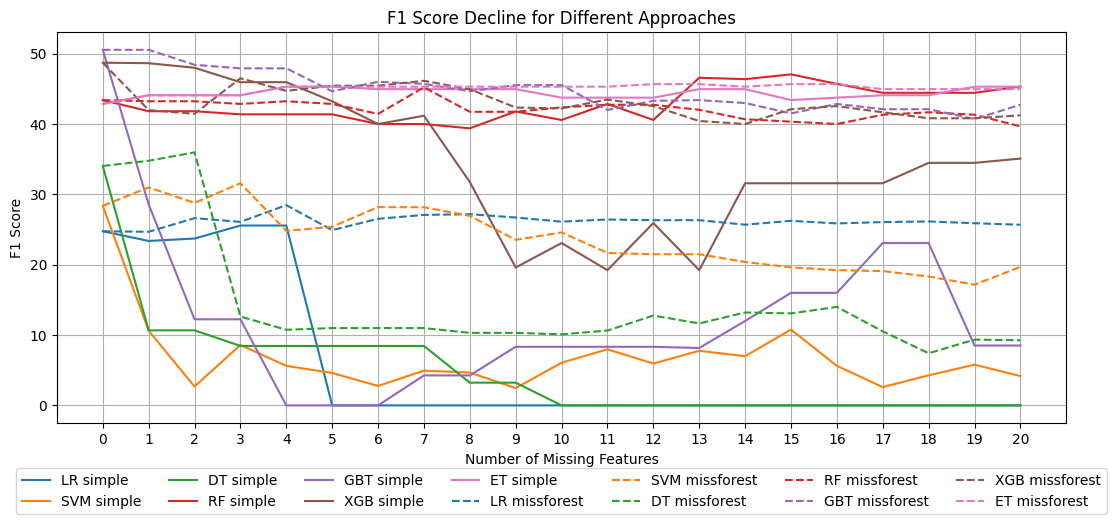

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

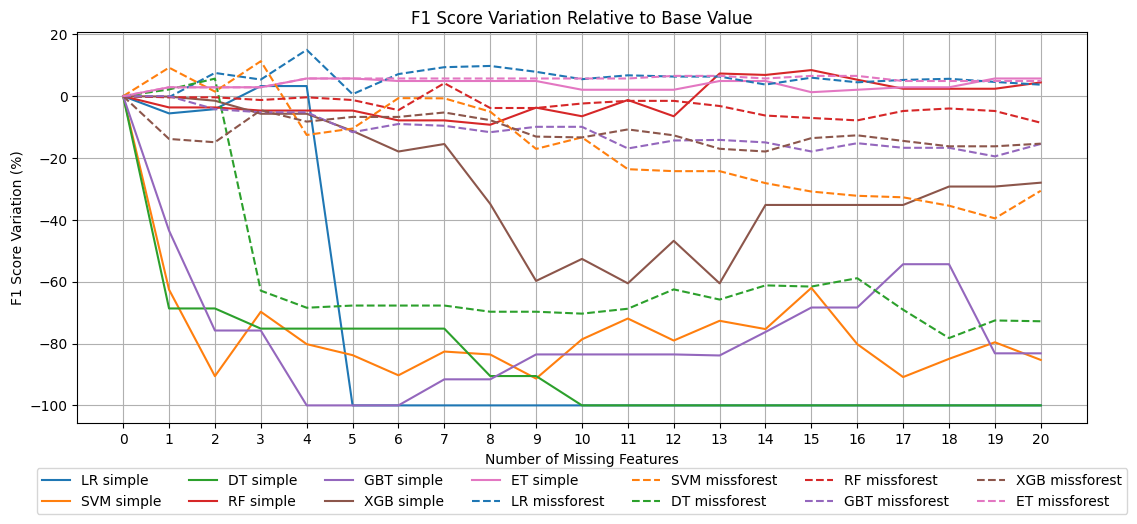

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

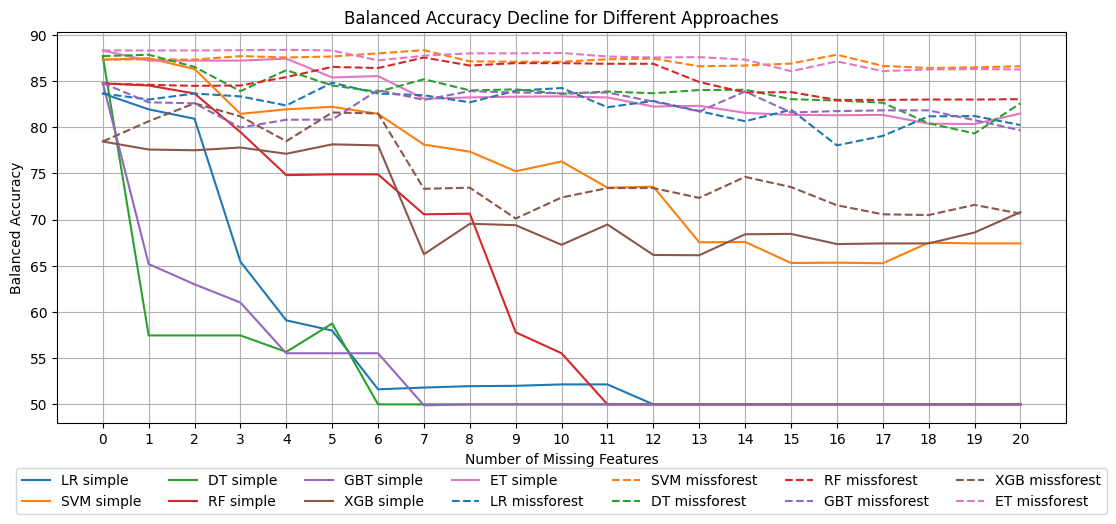

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

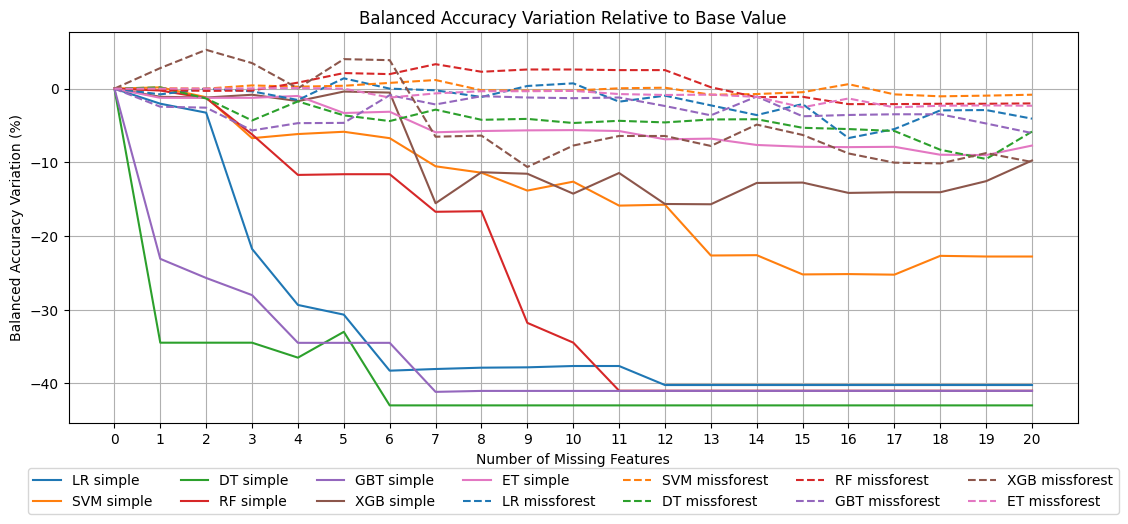

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario1_seed_2024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    38  1095  225   6      14.45   86.36        82.95     83.06     24.76   
1    38  1077  243   6      13.52   86.36        81.59     81.74     23.38   
2    37  1089  231   7      13.81   84.09        82.50     82.55     23.72   
3    39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
4    39  1098  222   5      14.94   88.64        83.18     83.36     25.57   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  38  1160  160   6      19.19   86.36        87.88     87.83     31.40   
584  37  1162  158   7      18.97   84.09        88.03     87.90     30.96   
585  37  1167  153   7      19.47   84.09        88.41     88.27     31.62   
586  37  1168  152   7      19.58   84.09        88.48     88.34     31.76   
587  37  1167  153   7      19.47   84.09        88.41     88.27     31.62   

     balanced_accuracy  num_feat_missing  \
0                84.66                 0   
1                83.98                 1   
2                83.30                 2   
3                85.91                 3   
4                85.91                 4   
..                 ...               ...   
583              87.12                16   
584              86.06                17   
585              86.25                18   
586              86.29                19   
587              86.25                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                ['Quick Assets/Total Assets'] imputed      lr_perf   
2    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
3    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
4    ['Quick Assets/Total Assets', 'Cash/Total Asse...      lr_perf   
..                                                 ...          ...   
583  ['Equity to Long-term Liability', 'Total debt/...  et2_perf_mf   
584  ['Equity to Long-term Liability', 'Total debt/...  et2_perf_mf   
585  ['Equity to Long-term Liability', 'Total debt/...  et2_perf_mf   
586  ['Equity to Long-term Liability', 'Total debt/...  et2_perf_mf   
587  ['Equity to Long-term Liability', 'Total debt/...  et2_perf_mf   

                   source              scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 1: standard          2024   
1    Taiwanese Bankruptcy  Scenario 1: standard          2024   
2    Taiwanese Bankruptcy  Scenario 1: standard          2024   
3    Taiwanese Bankruptcy  Scenario 1: standard          2024   
4    Taiwanese Bankruptcy  Scenario 1: standard          2024   
..                    ...                   ...           ...   
583  Taiwanese Bankruptcy  Scenario 1: standard          2024   
584  Taiwanese Bankruptcy  Scenario 1: standard          2024   
585  Taiwanese Bankruptcy  Scenario 1: standard          2024   
586  Taiwanese Bankruptcy  Scenario 1: standard          2024   
587  Taiwanese Bankruptcy  Scenario 1: standard          2024   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]